<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/examples/experiments/ST/ADMET_11_02_plot_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
print(torch.__version__)
print('cuda: ', torch.cuda.is_available())

2.1.0+cu118
cuda:  True


In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet
! pip install selfies  --quiet
! pip install pubchempy --quiet
! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet

! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet

#### Code

In [1]:
from os import walk
import os
file_types = ['bin', 'pth']

# clean certain type of file in path
def clean_files(path='/content/drive/MyDrive/ADMET/', file_types = ['pth', 'bin', 'pt', 'yml']):
    files = next(walk(path), (None, None, []))[2]
    for file in files:
        if isinstance(file, str):
            file_type = file.split('.')[-1]
            if file_type in file_types:
                os.remove(file); print(f'removed from {path}: {file} ')
# clean_files()

In [2]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [3]:
# test scripts.func_utils.py

from scripts.func_utils import *
from scripts.yaml_utils import *
from scripts.eval_utils import *
from scripts.preprocess_mols import *
from scripts.model_architecture import *
from scripts.dataset import *
from scripts.train import *

from tdc.utils import retrieve_label_name_list
import pandas as pd
from scripts.get_vocab import *

from tdc.single_pred import ADME
from tdc.single_pred import Tox
label_list = retrieve_label_name_list('herg_central')


In [4]:
def eval_multi_run(model_type, name, folder_list, repeat_time=3,
                   run_type=None, metrics_dict={}):
    if isinstance(name, str): name = [name]
    if isinstance(folder_list, str): folder_list = [folder_list]
    if run_type == None: run_type = 'ST' if len(name) == 1 else 'MT'

    for folder_ in folder_list:
        print('checking', folder_)
        try:
            perform_list = []
            for i in range(repeat_time):
                yml_name = f'{folder_}/{model_type}_{run_type}_{i}.yml'
                try:
                    p = yml_report(yml_name, ver=False); perform_list.append(p)
                except:
                    print('cannot read', yml_name); break
            if len(perform_list) != 0:
                eval_perf_list(perform_list, name, metrics_dict=metrics_dict)
        except: pass
    print()

In [12]:
def roc_curve_batch(probs_list, label_list, model_types,
                    figure_title=None, figure_file=None):
    '''
        y_pred is a list of length n.  (0,1)
        y_label is a list of same length. 0/1
        https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
    '''
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import roc_auc_score
    assert len(probs_list) == len(label_list)
    assert len(probs_list) == len(model_types)
    fig = plt.figure()
    for y_pred, y_label, method_name in zip(probs_list, label_list, model_types):
        y_label = np.array(y_label)
        y_pred =  np.array(y_pred)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        fpr[0], tpr[0], _ = roc_curve(y_label, y_pred)
        roc_auc[0] = auc(fpr[0], tpr[0])
        lw = 2
        plt.plot(fpr[0], tpr[0],
                lw=lw, label= method_name + ' (area = %0.3f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    fontsize = 14
    plt.xlabel('False Positive Rate', fontsize = fontsize)
    plt.ylabel('True Positive Rate', fontsize = fontsize)
    title = 'AUROC'
    if figure_title != None: title += ' on ' + figure_title + ' test set'
    plt.title(title, fontsize=fontsize)
    # plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    if figure_file != None:
        plt.savefig(figure_file)
    plt.show(); plt.close()
    return

def prc_curve_batch(probs_list, label_list, model_types,
                    figure_title=None, figure_file=None):
    '''
        y_pred is a list of length n.  (0,1)
        y_label is a list of same length. 0/1
        reference:
            https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
    '''
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_recall_curve, average_precision_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import auc
    assert len(probs_list) == len(label_list)
    assert len(probs_list) == len(model_types)
    fig = plt.figure()
    for y_pred, y_label, method_name in zip(probs_list, label_list, model_types):
        lr_precision, lr_recall, _ = precision_recall_curve(y_label, y_pred)
        label_name = ' (area = %0.3f)' % average_precision_score(y_label, y_pred)
        plt.plot(lr_recall, lr_precision, lw = 2, label= method_name+label_name)
    fontsize = 14
    plt.xlabel('Recall', fontsize = fontsize)
    plt.ylabel('Precision', fontsize = fontsize)
    # plt.title('Precision Recall Curve')
    title = 'PRAUC'
    if figure_title != None: title += ' on ' + figure_title + ' test set'
    plt.title(title, fontsize=fontsize)
    # plt.title('PRC', fontsize=fontsize)
    plt.legend()
    if figure_file != None:
        plt.savefig(figure_file)
    plt.show(); plt.close()
    return


#### Constant and configs

In [5]:
dropout = 0.3
lr = 3e-4
wd = 1e-5
MAX_EPOCH = 1000
patience = 30           # stop if loss no decrease after epochs # patience
verbose_frequency = 100 # print evaluation every # verbose_frequency epoch
batch_size = 128

# special for MLP
MLP_in_dim = 167     # len of MACCS fingerprints
MLP_hid_dims = [128, 64, 32, 16]   # hidden dims

# special for AttentiveFP
graph_feat_size = 300
n_layers = 5
num_timesteps = 1   # times of updating the graph representations with GRU

# special for GIN: pretrain model types for selection:
pre_models_GIN = ['gin_supervised_contextpred', 'gin_supervised_infomax',
                     'gin_supervised_edgepred', 'gin_supervised_masking']
pre_model_num = 0    # choose from pre_models for GIN
in_dim = 256
hid_dims = [128, 64, 32, 16]

# if VOCAB_TYPE == 'smiles':
import yaml
def load_vocab(VOCAB_TYPE):
    try:
        with open(f'vocab/{VOCAB_TYPE}.yml', 'r') as f: data = yaml.safe_load(f)
        vocab = data['vocab']; assert VOCAB_TYPE == data['vocab_type']
    except: vocab = None
    return vocab

# special for RNN:
print('Vocab type for RNN:', VOCAB_TYPE)
VOCAB = load_vocab(VOCAB_TYPE)
Bid = True
GRU_num_layers = 3
GRU_dim = 256

scale_dict = None
uw = False # uncertainty weight

def get_config(model_type, names,
               pre_model_num=pre_model_num, scale_dict=scale_dict):
    """
    Get config to initialize model
        param model_type: str, ['MLP', 'AttentiveFP', 'GIN', 'RNN']
        param names: list, task names
        param scale_dict: dict,
            if the task is regression, could scale label values
                            {name: [value_min, value_max], ...}
        param pre_model_num: int, [0, 1, 2, 3]
            if model_type is 'GIN', 4 types of pretrained models to choose from
    Returns config that could be used as PRED(**config)
    """
    pre_models_GIN = ['gin_supervised_contextpred', 'gin_supervised_infomax',
                         'gin_supervised_edgepred', 'gin_supervised_masking']

    # print(scale_dict)
    if isinstance(names, str): names = [names]
    IS_R = [names_dict[name] for name in names]
    config_MLP = {'model_type': 'MLP',
            'in_dim': MLP_in_dim,
            'hid_dims': MLP_hid_dims,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'IS_R': IS_R,
            'batch_size': batch_size,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': f'ckpt_MLP.pt',
            'scale_dict': scale_dict}

    config_ATF = {'model_type': 'AttentiveFP',
            'graph_feat_size': graph_feat_size,
            'num_timesteps': num_timesteps,
            'n_layers': n_layers,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'IS_R': IS_R,
            'batch_size': batch_size,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': 'ckpt_AT.pt',
            'scale_dict': scale_dict}

    config_GIN = {'model_type': 'GIN',
            'pretrain_model': pre_models_GIN[pre_model_num],
            'in_dim': in_dim,
            'hid_dims': hid_dims,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'batch_size': batch_size,
            'IS_R': IS_R,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': f'ckpt_GIN_{pre_models_GIN[pre_model_num]}.pt',
            'scale_dict': scale_dict}

    config_RNN = {'model_type': 'RNN',
              'vocab': VOCAB,
              'vocab_type': VOCAB_TYPE,
              'Bidirect': Bid,
              'num_layers': GRU_num_layers,
              'GRU_dim': GRU_dim,
              'out_dim': len(names),
              'prop_names': names,
              'dropout': dropout,
              'IS_R': IS_R,
              'device': 'cuda',
              'batch_size': batch_size,
              'lr': lr,
              'wd': wd,
              'patience': patience,
              'verbose_freq': verbose_frequency,
              'model_path': f'ckpt_RNN_{VOCAB_TYPE}.pt',
              'scale_dict': scale_dict}

    if model_type == 'MLP':           con_MO = config_MLP
    elif model_type == 'AttentiveFP': con_MO = config_ATF
    elif model_type == 'GIN':         con_MO = config_GIN
    elif model_type == 'RNN':         con_MO = config_RNN
    else: print('Error !{MLP, AttentiveFP, GIN, RNN}'); return None

    con_MO['config_path'] = con_MO['model_path'].split('.')[0] + '.yml'
    # different weight of task, initial weight the same
    con_MO['weight_loss'] = [float(1.0)] * len(names)
    con_MO['MAX_EPOCH'] = MAX_EPOCH
    con_MO['uncertainty_weight'] = uw
    return con_MO



Vocab type for RNN: smiles


### plot figures

Found local copy...
Loading...
Done!


collect data for:  ['Caco2_Wang']

START scaling train valid test data set: 
---> scale Caco2_Wang | min -7.760 | max -3.510
Finished scaling process | dict_scale: {'Caco2_Wang': [-7.7600002, -3.51]} 

--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  Caco2_Wang_scale/RNN_ST_2.pt
[Test] Loss: 0.023
*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.505  &0.416  &0.645  &0.346


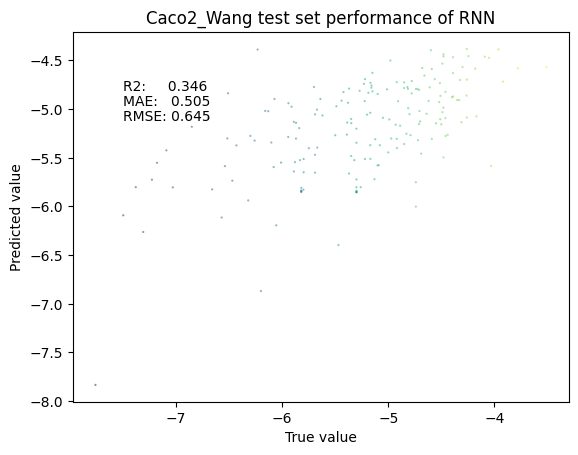

{'Caco2_Wang': [0.5046157746882252,
  0.41550389471432514,
  0.6445959158374532,
  0.34590586847326643],
 'loss': 0.022527258843183517}

In [6]:
yml_report('Caco2_Wang_scale/RNN_ST_2.yml', recalculate=True)

Found local copy...
Loading...
Done!


collect data for:  ['Lipophilicity_AstraZeneca']

START scaling train valid test data set: 
---> scale Lipophilicity_AstraZeneca | min -1.500 | max 4.500
Finished scaling process | dict_scale: {'Lipophilicity_AstraZeneca': [-1.5, 4.5]} 

--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 652 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done 837 out of 840 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 840 out of 840 | elapsed:    4.5s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  Lipophilicity_AstraZeneca_scale/AttentiveFP_ST_1.pt
[Test] Loss: 0.009
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.410  &0.331  &0.575  &0.776


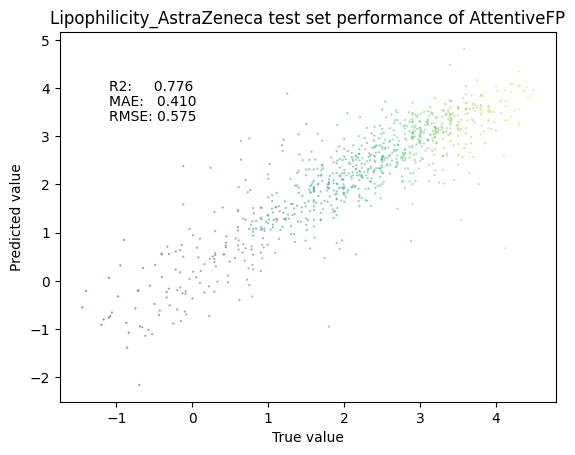

{'Lipophilicity_AstraZeneca': [0.4099790017054017,
  0.3311863909987334,
  0.5754879590388781,
  0.7758429036253711],
 'loss': 0.009348784839468343}

In [7]:
yml_name = 'Lipophilicity_AstraZeneca_scale/AttentiveFP_ST_1.yml'
yml_report(yml_name, recalculate=True)

Found local copy...
Loading...
Done!


repeated num # 3 idx 2 has the lowest loss from [0.014077597922021215, 0.013949783621253549, 0.013443326557075584]
******************** Caco2_Wang ******************** 
	|       mae      |       rmse      |       r2      
	&0.393$\pm$0.007  &0.500$\pm$0.005  &0.607$\pm$0.008  
 idx 2: &0.385            &0.493            &0.618            

best model for Caco2_Wang, MLP: Caco2_Wang_scale/MLP_ST_2.yml
collect data for:  ['Caco2_Wang']

START scaling train valid test data set: 
---> scale Caco2_Wang | min -7.760 | max -3.510
Finished scaling process | dict_scale: {'Caco2_Wang': [-7.7600002, -3.51]} 

--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  Caco2_Wang_scale/MLP_ST_2.pt
[Test] Loss: 0.013
*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.385  &0.243  &0.493  &0.618


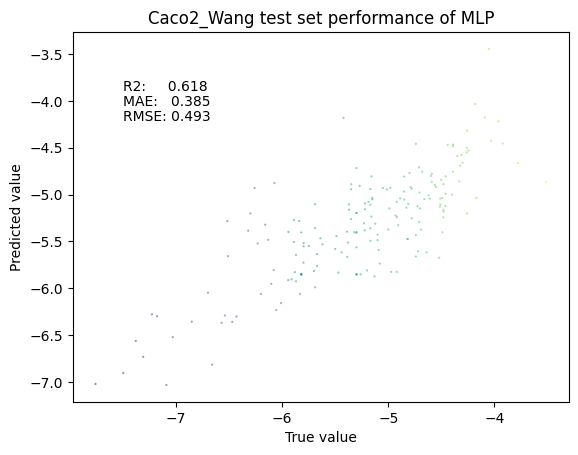

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [0.010073060190284646, 0.009021656198815986, 0.00943417143035721]
******************** Caco2_Wang ******************** 
	|       mae      |       rmse      |       r2      
	&0.338$\pm$0.006  &0.414$\pm$0.009  &0.730$\pm$0.012  
 idx 1: &0.331            &0.404            &0.743            

best model for Caco2_Wang, AttentiveFP: Caco2_Wang_scale/AttentiveFP_ST_1.yml
collect data for:  ['Caco2_Wang']

START scaling train valid test data set: 
---> scale Caco2_Wang | min -7.760 | max -3.510
Finished scaling process | dict_scale: {'Caco2_Wang': [-7.7600002, -3.51]} 

--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 160 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done 182 out of 182 | elapsed:    3.3s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  Caco2_Wang_scale/AttentiveFP_ST_1.pt
[Test] Loss: 0.009
*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.331  &0.163  &0.404  &0.743


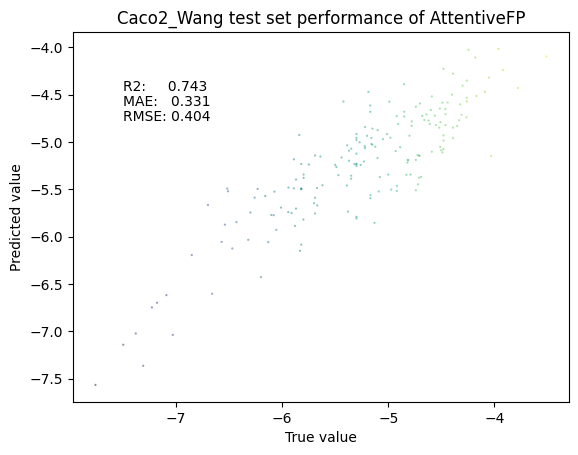

Found local copy...
Loading...
Done!



repeated num # 3 idx 0 has the lowest loss from [0.01365291450049851, 0.017191066191746637, 0.015879969347964276]
******************** Caco2_Wang ******************** 
	|       mae      |       rmse      |       r2      
	&0.418$\pm$0.027  &0.530$\pm$0.025  &0.557$\pm$0.042  
 idx 0: &0.383            &0.497            &0.612            

best model for Caco2_Wang, GIN: Caco2_Wang_scale/GIN_ST_0.yml
collect data for:  ['Caco2_Wang']

START scaling train valid test data set: 
---> scale Caco2_Wang | min -7.760 | max -3.510
Finished scaling process | dict_scale: {'Caco2_Wang': [-7.7600002, -3.51]} 

--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  Caco2_Wang_scale/GIN_ST_0.pt
[Test] Loss: 0.013
*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.383  &0.247  &0.497  &0.612


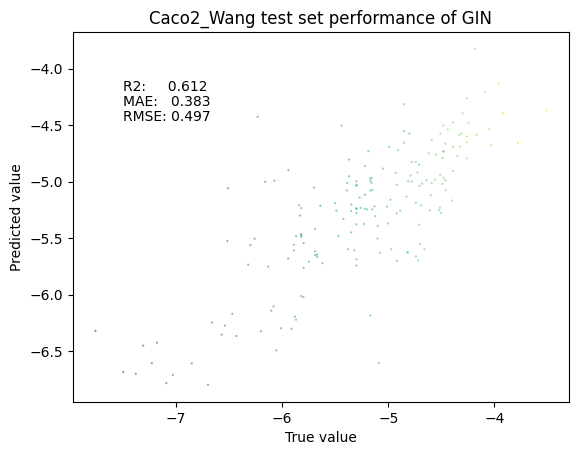

Found local copy...
Loading...
Done!



repeated num # 3 idx 0 has the lowest loss from [0.022208291095691723, 0.022280575154901863, 0.023003673815465236]
******************** Caco2_Wang ******************** 
	|       mae      |       rmse      |       r2      
	&0.503$\pm$0.003  &0.637$\pm$0.005  &0.360$\pm$0.010  
 idx 0: &0.505            &0.633            &0.369            

best model for Caco2_Wang, RNN: Caco2_Wang_scale/RNN_ST_0.yml
collect data for:  ['Caco2_Wang']

START scaling train valid test data set: 
---> scale Caco2_Wang | min -7.760 | max -3.510
Finished scaling process | dict_scale: {'Caco2_Wang': [-7.7600002, -3.51]} 

--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  Caco2_Wang_scale/RNN_ST_0.pt
[Test] Loss: 0.021
*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.505  &0.401  &0.633  &0.369


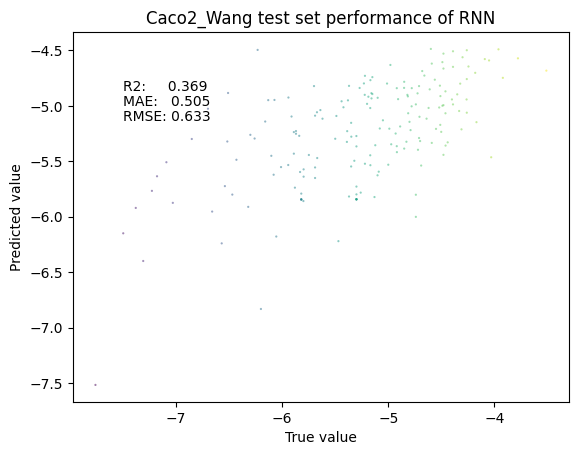

Found local copy...
Loading...
Done!



repeated num # 3 idx 0 has the lowest loss from [0.02028751586164747, 0.021011428038279215, 0.020934315238680157]
******************** Lipophilicity_AstraZeneca ******************** 
	|       mae      |       rmse      |       r2      
	&0.663$\pm$0.011  &0.864$\pm$0.007  &0.495$\pm$0.008  
 idx 0: &0.654            &0.855            &0.506            

best model for Lipophilicity_AstraZeneca, MLP: Lipophilicity_AstraZeneca_scale/MLP_ST_0.yml
collect data for:  ['Lipophilicity_AstraZeneca']

START scaling train valid test data set: 
---> scale Lipophilicity_AstraZeneca | min -1.500 | max 4.500
Finished scaling process | dict_scale: {'Lipophilicity_AstraZeneca': [-1.5, 4.5]} 

--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  Lipophilicity_AstraZeneca_scale/MLP_ST_0.pt
[Test] Loss: 0.021
*************** Lipophilicity_AstraZeneca ***************

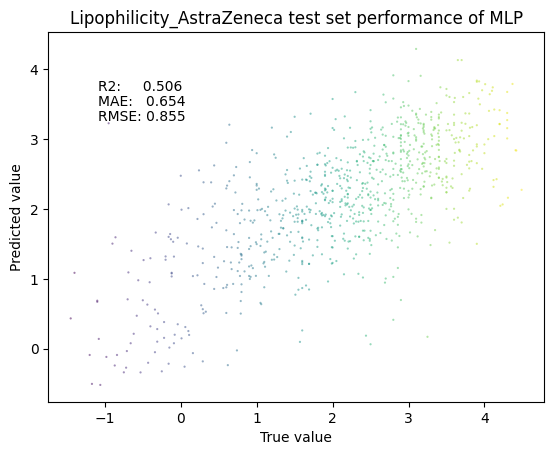

Found local copy...
Loading...
Done!


repeated num # 3 idx 1 has the lowest loss from [0.007352150373515629, 0.006638023186297644, 0.007119310044106983]
******************** Lipophilicity_AstraZeneca ******************** 
	|       mae      |       rmse      |       r2      
	&0.365$\pm$0.009  &0.503$\pm$0.011  &0.824$\pm$0.007  
 idx 1: &0.353            &0.489            &0.834            

best model for Lipophilicity_AstraZeneca, AttentiveFP: Lipophilicity_AstraZeneca_scale/AttentiveFP_ST_1.yml
collect data for:  ['Lipophilicity_AstraZeneca']

START scaling train valid test data set: 
---> scale Lipophilicity_AstraZeneca | min -1.500 | max 4.500
Finished scaling process | dict_scale: {'Lipophilicity_AstraZeneca': [-1.5, 4.5]} 

--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 745 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 837 out of 840 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 840 out of 840 | elapsed:    1.3s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  Lipophilicity_AstraZeneca_scale/AttentiveFP_ST_1.pt
[Test] Loss: 0.009
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.410  &0.331  &0.575  &0.776


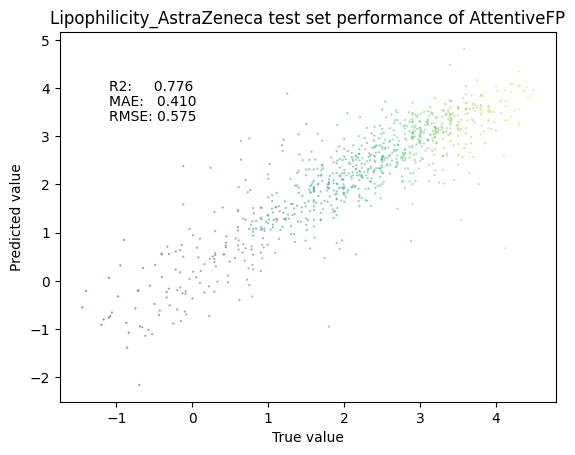


repeated num # 3 idx 0 has the lowest loss from [0.012082605418704805, 0.012250324516069321, 0.014610148327691214]
******************** Lipophilicity_AstraZeneca ******************** 
	|       mae      |       rmse      |       r2      
	&0.522$\pm$0.028  &0.683$\pm$0.030  &0.684$\pm$0.028  
 idx 0: &0.498            &0.660            &0.706            

best model for Lipophilicity_AstraZeneca, GIN: Lipophilicity_AstraZeneca_scale/GIN_ST_0.yml


Found local copy...
Loading...
Done!


collect data for:  ['Lipophilicity_AstraZeneca']

START scaling train valid test data set: 
---> scale Lipophilicity_AstraZeneca | min -1.500 | max 4.500
Finished scaling process | dict_scale: {'Lipophilicity_AstraZeneca': [-1.5, 4.5]} 

--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  Lipophilicity_AstraZeneca_scale/GIN_ST_0.pt
[Test] Loss: 0.012
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.498  &0.435  &0.660  &0.706


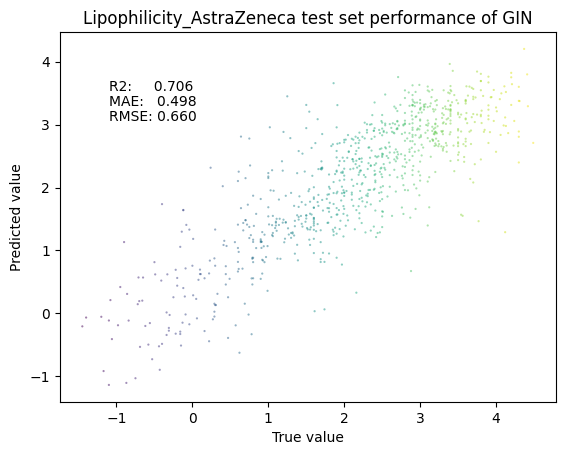

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [0.01960491169066656, 0.02007693506422497, 0.018522064033008757]
******************** Lipophilicity_AstraZeneca ******************** 
	|       mae      |       rmse      |       r2      
	&0.624$\pm$0.007  &0.836$\pm$0.014  &0.527$\pm$0.016  
 idx 2: &0.614            &0.817            &0.549            

best model for Lipophilicity_AstraZeneca, RNN: Lipophilicity_AstraZeneca_scale/RNN_ST_2.yml
collect data for:  ['Lipophilicity_AstraZeneca']

START scaling train valid test data set: 
---> scale Lipophilicity_AstraZeneca | min -1.500 | max 4.500
Finished scaling process | dict_scale: {'Lipophilicity_AstraZeneca': [-1.5, 4.5]} 

--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  Lipophilicity_AstraZeneca_scale/RNN_ST_2.pt
[Test] Loss: 0.019
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.614  &0.667  &0

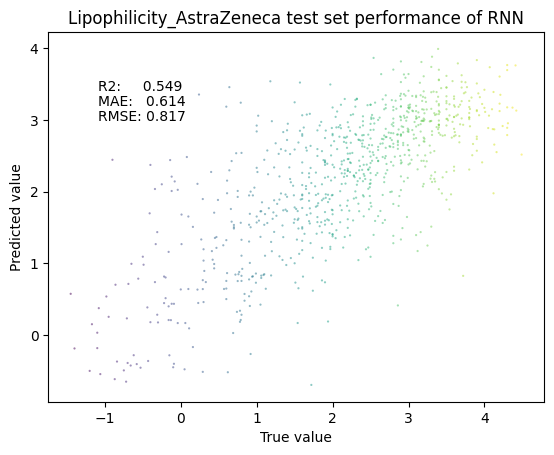


repeated num # 3 idx 2 has the lowest loss from [0.008915808983147144, 0.008510292507708073, 0.006729631684720516]
******************** HydrationFreeEnergy_FreeSolv ******************** 
	|       mae      |       rmse      |       r2      
	&2.202$\pm$0.178  &2.589$\pm$0.156  &0.589$\pm$0.049  
 idx 2: &1.965            &2.371            &0.656            

best model for HydrationFreeEnergy_FreeSolv, MLP: HydrationFreeEnergy_FreeSolv_scale/MLP_ST_2.yml


Found local copy...
Loading...
Done!


collect data for:  ['HydrationFreeEnergy_FreeSolv']

START scaling train valid test data set: 
---> scale HydrationFreeEnergy_FreeSolv | min -25.470 | max 3.430
Finished scaling process | dict_scale: {'HydrationFreeEnergy_FreeSolv': [-25.47, 3.43]} 

--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  HydrationFreeEnergy_FreeSolv_scale/MLP_ST_2.pt
[Test] Loss: 0.007
*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&1.965  &5.621  &2.371  &0.656


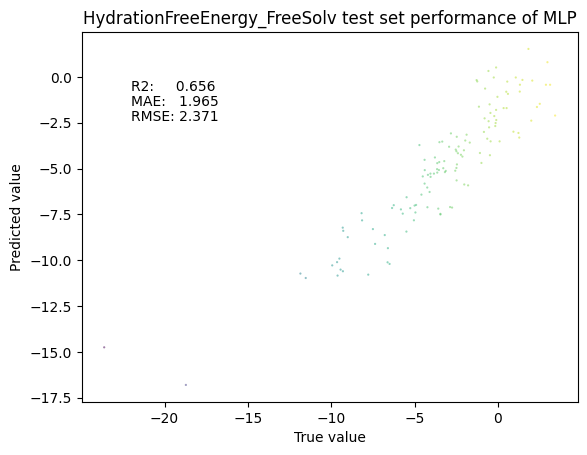

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [0.0026073255576193333, 0.0029375646263360977, 0.0024055205285549164]
******************** HydrationFreeEnergy_FreeSolv ******************** 
	|       mae      |       rmse      |       r2      
	&1.069$\pm$0.060  &1.486$\pm$0.061  &0.812$\pm$0.016  
 idx 2: &1.009            &1.417            &0.830            

best model for HydrationFreeEnergy_FreeSolv, AttentiveFP: HydrationFreeEnergy_FreeSolv_scale/AttentiveFP_ST_2.yml
collect data for:  ['HydrationFreeEnergy_FreeSolv']

START scaling train valid test data set: 
---> scale HydrationFreeEnergy_FreeSolv | min -25.470 | max 3.430
Finished scaling process | dict_scale: {'HydrationFreeEnergy_FreeSolv': [-25.47, 3.43]} 

--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 128 out of 128 | elapsed:    0.1s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  HydrationFreeEnergy_FreeSolv_scale/AttentiveFP_ST_2.pt
[Test] Loss: 0.002
*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&0.809  &1.339  &1.157  &0.918


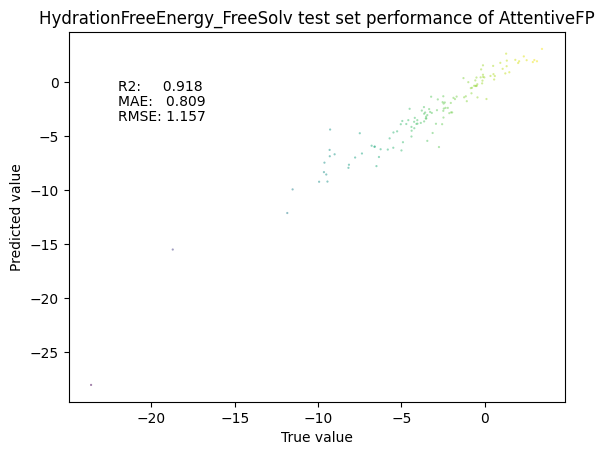

Found local copy...
Loading...



repeated num # 3 idx 1 has the lowest loss from [0.0066806962713599205, 0.0029829367995262146, 0.0055803535506129265]
******************** HydrationFreeEnergy_FreeSolv ******************** 
	|       mae      |       rmse      |       r2      
	&1.615$\pm$0.243  &2.033$\pm$0.332  &0.740$\pm$0.079  
 idx 1: &1.274            &1.578            &0.848            

best model for HydrationFreeEnergy_FreeSolv, GIN: HydrationFreeEnergy_FreeSolv_scale/GIN_ST_1.yml
collect data for:  ['HydrationFreeEnergy_FreeSolv']


Done!



START scaling train valid test data set: 
---> scale HydrationFreeEnergy_FreeSolv | min -25.470 | max 3.430
Finished scaling process | dict_scale: {'HydrationFreeEnergy_FreeSolv': [-25.47, 3.43]} 

--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  HydrationFreeEnergy_FreeSolv_scale/GIN_ST_1.pt
[Test] Loss: 0.003
*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&1.274  &2.491  &1.578  &0.848


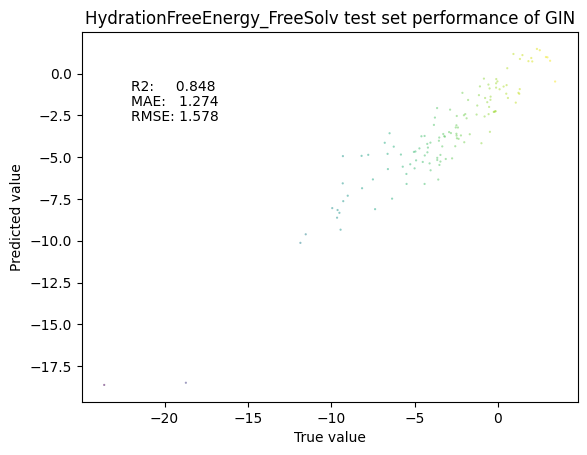

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [0.004297131206840277, 0.004277694970369339, 0.00394971389323473]
******************** HydrationFreeEnergy_FreeSolv ******************** 
	|       mae      |       rmse      |       r2      
	&1.427$\pm$0.014  &1.867$\pm$0.036  &0.787$\pm$0.008  
 idx 2: &1.430            &1.816            &0.798            

best model for HydrationFreeEnergy_FreeSolv, RNN: HydrationFreeEnergy_FreeSolv_scale/RNN_ST_2.yml
collect data for:  ['HydrationFreeEnergy_FreeSolv']

START scaling train valid test data set: 
---> scale HydrationFreeEnergy_FreeSolv | min -25.470 | max 3.430
Finished scaling process | dict_scale: {'HydrationFreeEnergy_FreeSolv': [-25.47, 3.43]} 

--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  HydrationFreeEnergy_FreeSolv_scale/RNN_ST_2.pt
[Test] Loss: 0.004
*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     

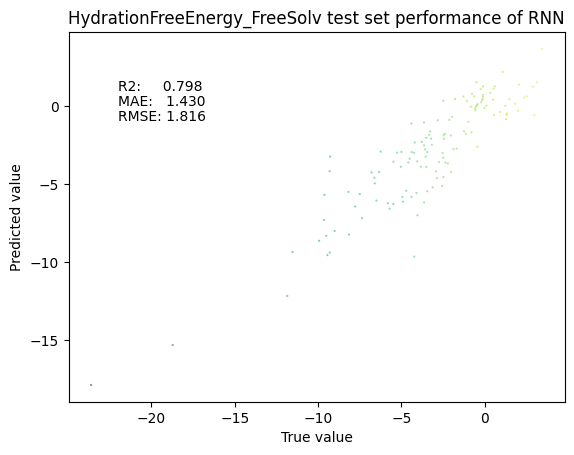

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [0.006705403118907569, 0.006687083947873545, 0.0067703555485528555]
******************** Solubility_AqSolDB ******************** 
	|       mae      |       rmse      |       r2      
	&0.920$\pm$0.009  &1.255$\pm$0.003  &0.710$\pm$0.002  
 idx 1: &0.931            &1.252            &0.711            

best model for Solubility_AqSolDB, MLP: Solubility_AqSolDB_scale/MLP_ST_1.yml
collect data for:  ['Solubility_AqSolDB']

START scaling train valid test data set: 
---> scale Solubility_AqSolDB | min -13.172 | max 2.138
Finished scaling process | dict_scale: {'Solubility_AqSolDB': [-13.1719, 2.1376816201]} 

--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  Solubility_AqSolDB_scale/MLP_ST_1.pt
[Test] Loss: 0.007
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.931  &1

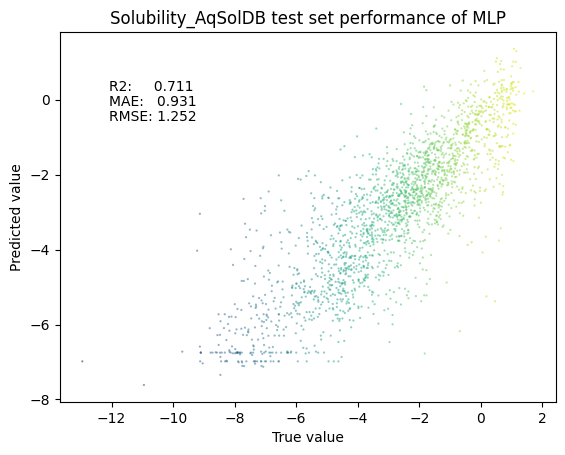

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [0.004391649786479965, 0.004325797255029659, 0.004242001045383289]
******************** Solubility_AqSolDB ******************** 
	|       mae      |       rmse      |       r2      
	&0.691$\pm$0.007  &1.006$\pm$0.007  &0.813$\pm$0.003  
 idx 2: &0.682            &0.997            &0.817            

best model for Solubility_AqSolDB, AttentiveFP: Solubility_AqSolDB_scale/AttentiveFP_ST_2.yml
collect data for:  ['Solubility_AqSolDB']

START scaling train valid test data set: 
---> scale Solubility_AqSolDB | min -13.172 | max 2.138
Finished scaling process | dict_scale: {'Solubility_AqSolDB': [-13.1719, 2.1376816201]} 

--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 1660 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 1996 out of 1996 | elapsed:    2.3s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  Solubility_AqSolDB_scale/AttentiveFP_ST_2.pt
[Test] Loss: 0.004
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.682  &0.994  &0.997  &0.817


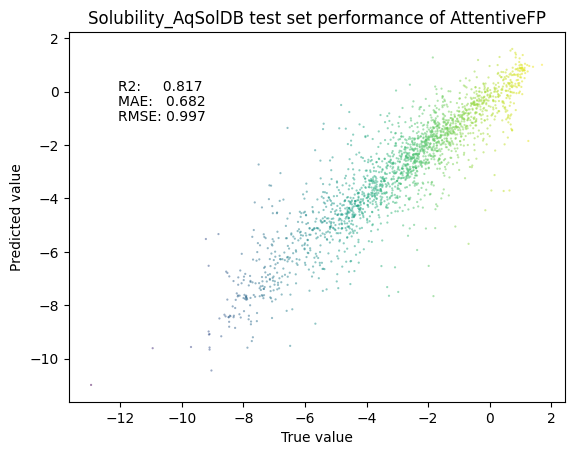


repeated num # 3 idx 1 has the lowest loss from [0.005459754703517906, 0.005280250172039311, 0.005492871802651094]
******************** Solubility_AqSolDB ******************** 
	|       mae      |       rmse      |       r2      
	&0.790$\pm$0.009  &1.126$\pm$0.010  &0.766$\pm$0.004  
 idx 1: &0.777            &1.112            &0.772            

best model for Solubility_AqSolDB, GIN: Solubility_AqSolDB_scale/GIN_ST_1.yml


Found local copy...
Loading...
Done!


collect data for:  ['Solubility_AqSolDB']

START scaling train valid test data set: 
---> scale Solubility_AqSolDB | min -13.172 | max 2.138
Finished scaling process | dict_scale: {'Solubility_AqSolDB': [-13.1719, 2.1376816201]} 

--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  Solubility_AqSolDB_scale/GIN_ST_1.pt
[Test] Loss: 0.005
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.777  &1.238  &1.112  &0.772


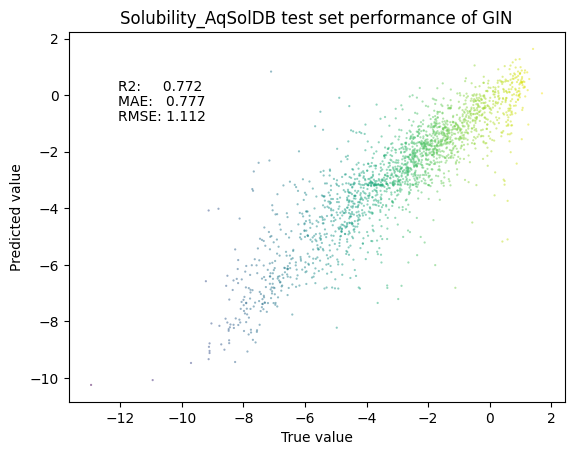

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [0.005334475729054583, 0.0052061934389905605, 0.005062424885724972]
******************** Solubility_AqSolDB ******************** 
	|       mae      |       rmse      |       r2      
	&0.768$\pm$0.005  &1.104$\pm$0.012  &0.775$\pm$0.005  
 idx 2: &0.772            &1.089            &0.781            

best model for Solubility_AqSolDB, RNN: Solubility_AqSolDB_scale/RNN_ST_2.yml
collect data for:  ['Solubility_AqSolDB']

START scaling train valid test data set: 
---> scale Solubility_AqSolDB | min -13.172 | max 2.138
Finished scaling process | dict_scale: {'Solubility_AqSolDB': [-13.1719, 2.1376816201]} 

--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  Solubility_AqSolDB_scale/RNN_ST_2.pt
[Test] Loss: 0.005
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.772  &1.187  &1.089  &0.781


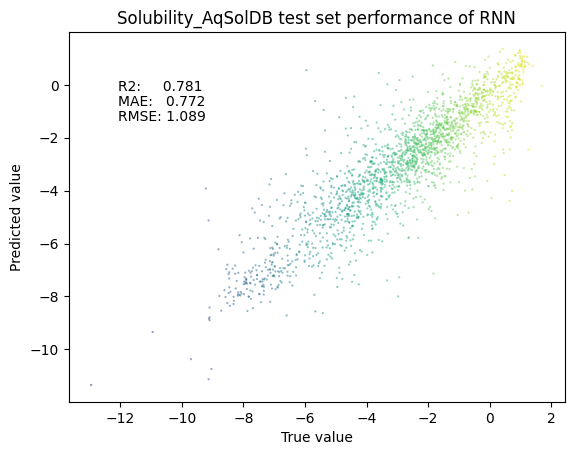

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [0.0035394736456564333, 0.0033902998461300404, 0.0035230769607450967]
******************** LD50_Zhu ******************** 
	|       mae      |       rmse      |       r2      
	&0.462$\pm$0.004  &0.623$\pm$0.006  &0.566$\pm$0.008  
 idx 1: &0.456            &0.614            &0.578            

best model for LD50_Zhu, MLP: LD50_Zhu_scale/MLP_ST_1.yml
collect data for:  ['LD50_Zhu']

START scaling train valid test data set: 
---> scale LD50_Zhu | min -0.343 | max 10.207
Finished scaling process | dict_scale: {'LD50_Zhu': [-0.3429999999999999, 10.207]} 

--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  LD50_Zhu_scale/MLP_ST_1.pt
[Test] Loss: 0.003
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.456  &0.377  &0.614  &0.578


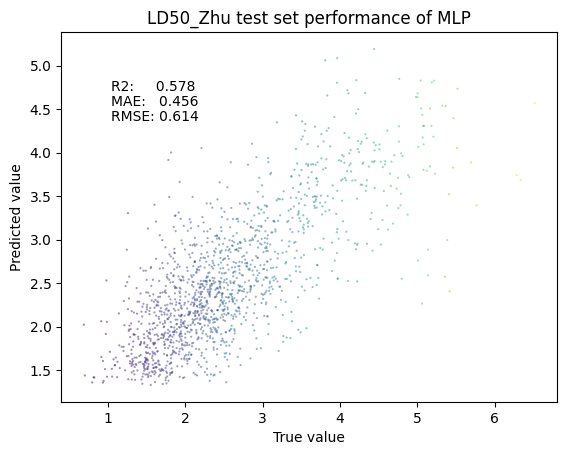

Found local copy...
Loading...



repeated num # 3 idx 1 has the lowest loss from [0.0032618335960842744, 0.0032559256942674124, 0.003351400268989878]
******************** LD50_Zhu ******************** 
	|       mae      |       rmse      |       r2      
	&0.451$\pm$0.006  &0.605$\pm$0.004  &0.590$\pm$0.005  
 idx 1: &0.450            &0.602            &0.594            

best model for LD50_Zhu, AttentiveFP: LD50_Zhu_scale/AttentiveFP_ST_1.yml
collect data for:  ['LD50_Zhu']


Done!
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.



START scaling train valid test data set: 
---> scale LD50_Zhu | min -0.343 | max 10.207
Finished scaling process | dict_scale: {'LD50_Zhu': [-0.3429999999999999, 10.207]} 

--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Done 1355 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 1474 out of 1477 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 1477 out of 1477 | elapsed:    1.7s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  LD50_Zhu_scale/AttentiveFP_ST_1.pt
[Test] Loss: 0.003
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.450  &0.362  &0.602  &0.594


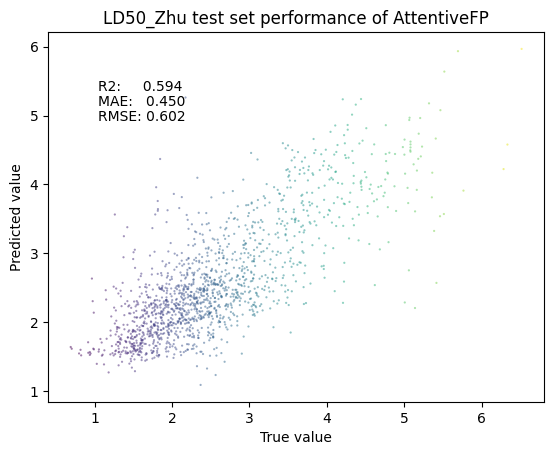


repeated num # 3 idx 0 has the lowest loss from [0.0030869548294135823, 0.00333595992183879, 0.0031382450398837057]
******************** LD50_Zhu ******************** 
	|       mae      |       rmse      |       r2      
	&0.439$\pm$0.011  &0.596$\pm$0.010  &0.603$\pm$0.013  
 idx 0: &0.428            &0.586            &0.615            

best model for LD50_Zhu, GIN: LD50_Zhu_scale/GIN_ST_0.yml


Found local copy...
Loading...
Done!


collect data for:  ['LD50_Zhu']

START scaling train valid test data set: 
---> scale LD50_Zhu | min -0.343 | max 10.207
Finished scaling process | dict_scale: {'LD50_Zhu': [-0.3429999999999999, 10.207]} 

--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  LD50_Zhu_scale/GIN_ST_0.pt
[Test] Loss: 0.003
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.428  &0.344  &0.586  &0.615


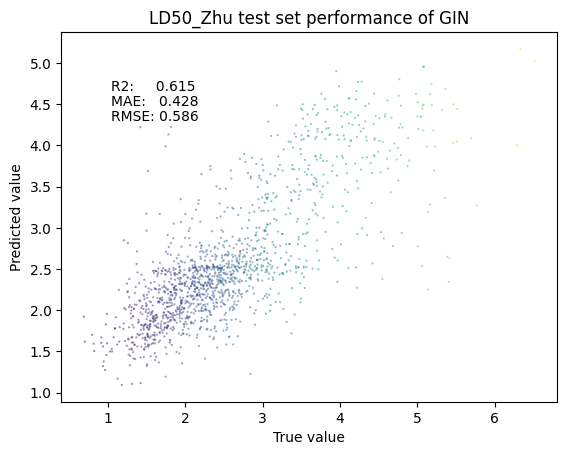

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [0.004173140410401972, 0.00395829627541327, 0.003968775151303756]
******************** LD50_Zhu ******************** 
	|       mae      |       rmse      |       r2      
	&0.500$\pm$0.007  &0.670$\pm$0.008  &0.498$\pm$0.012  
 idx 1: &0.498            &0.664            &0.507            

best model for LD50_Zhu, RNN: LD50_Zhu_scale/RNN_ST_1.yml
collect data for:  ['LD50_Zhu']

START scaling train valid test data set: 
---> scale LD50_Zhu | min -0.343 | max 10.207
Finished scaling process | dict_scale: {'LD50_Zhu': [-0.3429999999999999, 10.207]} 

--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  LD50_Zhu_scale/RNN_ST_1.pt
[Test] Loss: 0.004
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.498  &0.441  &0.664  &0.507


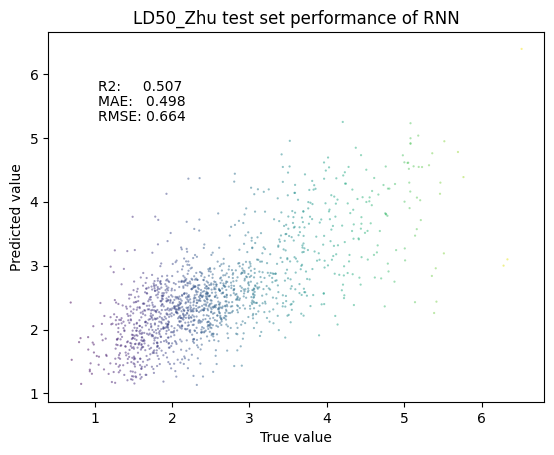

In [7]:
# check regression tasks done
repeat_time = 3

for name in names_reg:
    folder_name = f'{name}_scale' # check scaleed result
    for model_type in model_types:
        perfs = []
        for i in range(repeat_time):
            file_name = f'{folder_name}/{model_type}_ST_{i}.yml'
            try:
                p = yml_report(file_name)
                perfs.append(p)
            except:
                print(f'cannot open file {file_name}')
        best_idx = eval_perf_list(perfs, name, tok='&')
        file_name = f'{folder_name}/{model_type}_ST_{best_idx}.yml'
        print(f'best model for {name}, {model_type}: {file_name}')
        output = yml_report(file_name, return_all=True)


Found local copy...
Loading...
Done!


repeated num # 3 idx 2 has the lowest loss from [9.649714589118958, 9.630590319633484, 9.627918720245361]
******************** CYP2C19_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.782$\pm$0.002  &0.856$\pm$0.001  &0.811$\pm$0.001  
 idx 2: &0.781            &0.855            &0.810            

best model for CYP2C19_Veith, MLP: cls/CYP2C19_Veith/MLP_ST_2.yml
collect data for:  ['CYP2C19_Veith']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  cls/CYP2C19_Veith/MLP_ST_2.pt
[Test] Loss: 0.481
*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.781  &  0.783  &          0.742  &     0.802  &0.764  &0.771 &0.855 &   0.564 &   0.810


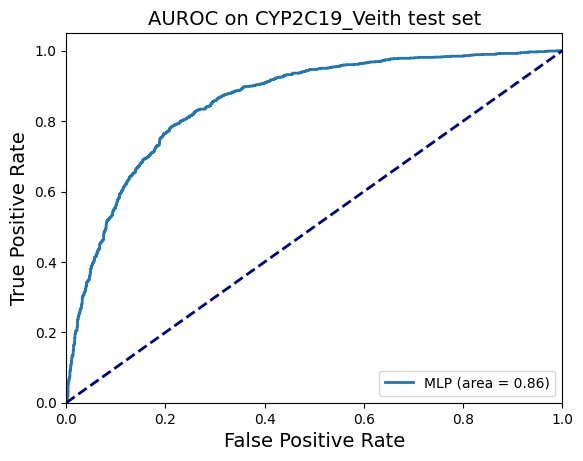

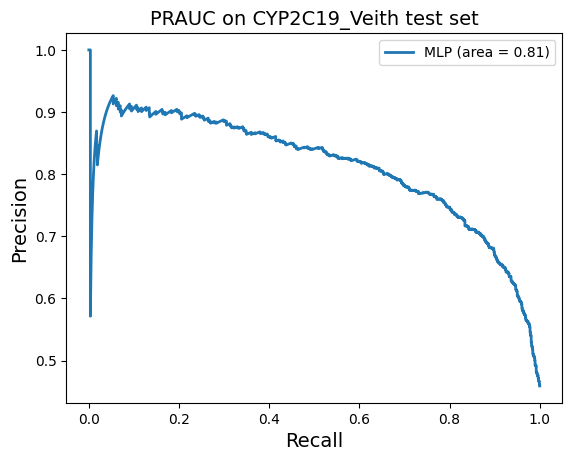

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [8.564451843500137, 8.541282385587692, 8.51417589187622]
******************** CYP2C19_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.814$\pm$0.003  &0.885$\pm$0.001  &0.848$\pm$0.006  
 idx 2: &0.818            &0.886            &0.857            

best model for CYP2C19_Veith, AttentiveFP: cls/CYP2C19_Veith/AttentiveFP_ST_2.yml
collect data for:  ['CYP2C19_Veith']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 652 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done 2533 out of 2533 | elapsed:    6.5s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  cls/CYP2C19_Veith/AttentiveFP_ST_2.pt
[Test] Loss: 0.426
*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.818  &  0.817  &          0.796  &     0.811  &0.824  &0.804 &0.886 &   0.634 &   0.857


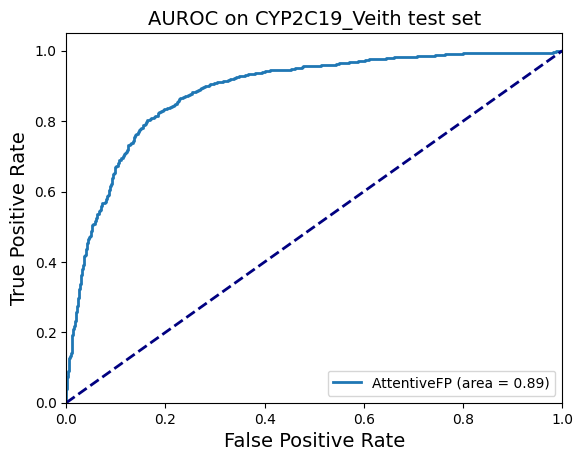

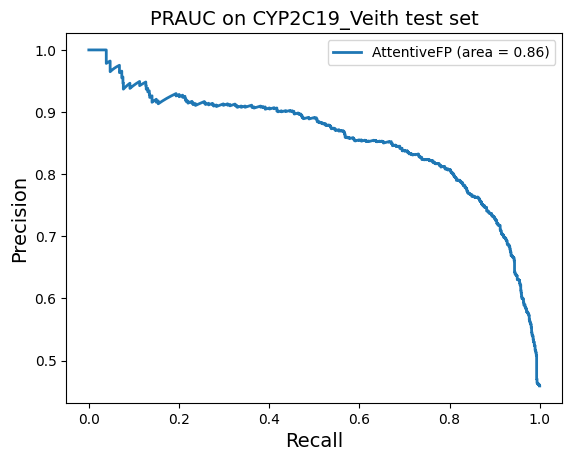

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [6.892902627587318, 6.901974409818649, 6.807516515254974]
******************** CYP2C19_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.859$\pm$0.001  &0.927$\pm$0.000  &0.911$\pm$0.001  
 idx 2: &0.860            &0.927            &0.911            

best model for CYP2C19_Veith, GIN: cls/CYP2C19_Veith/GIN_ST_2.yml
collect data for:  ['CYP2C19_Veith']
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  cls/CYP2C19_Veith/GIN_ST_2.pt
[Test] Loss: 0.340
*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.860  &  0.861  &          0.829  &     0.876  &0.847  &0.852 &0.927 &   0.721 &   0.911


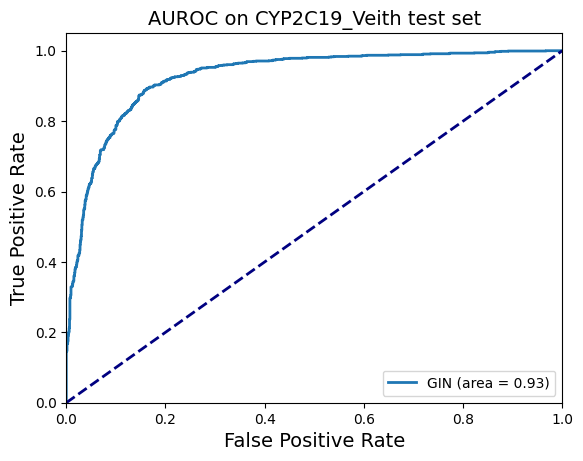

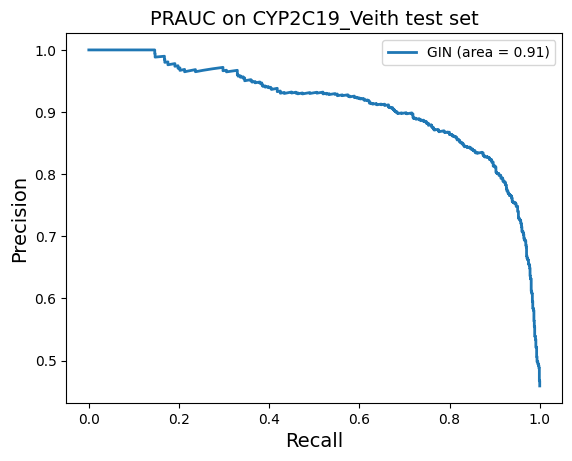

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [9.689525872468948, 9.69476655125618, 9.574535936117172]
******************** CYP2C19_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.783$\pm$0.004  &0.850$\pm$0.002  &0.801$\pm$0.010  
 idx 2: &0.789            &0.850            &0.796            

best model for CYP2C19_Veith, RNN: cls/CYP2C19_Veith/RNN_ST_2.yml
collect data for:  ['CYP2C19_Veith']
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  cls/CYP2C19_Veith/RNN_ST_2.pt
[Test] Loss: 0.479
*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.789  &  0.790  &          0.754  &     0.803  &0.777  &0.778 &0.850 &   0.579 &   0.796


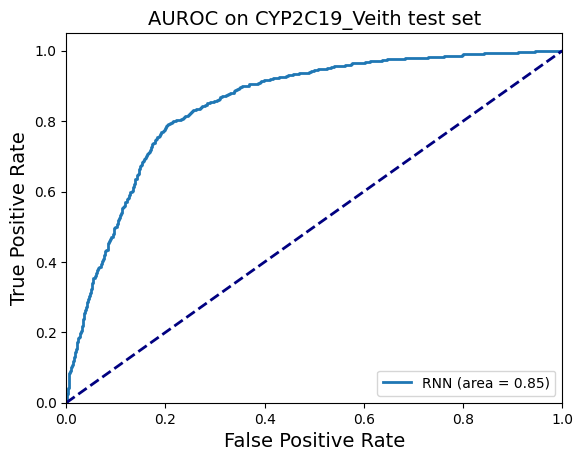

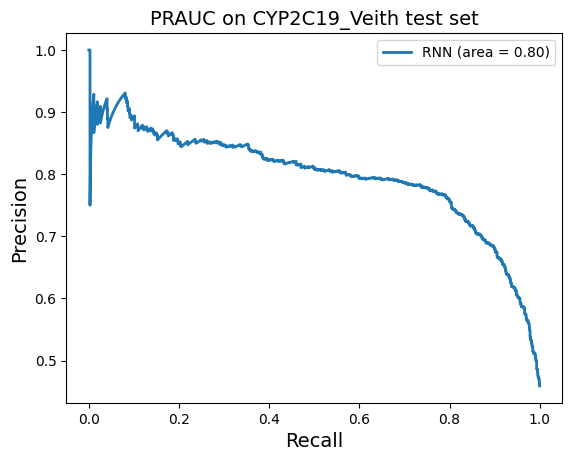

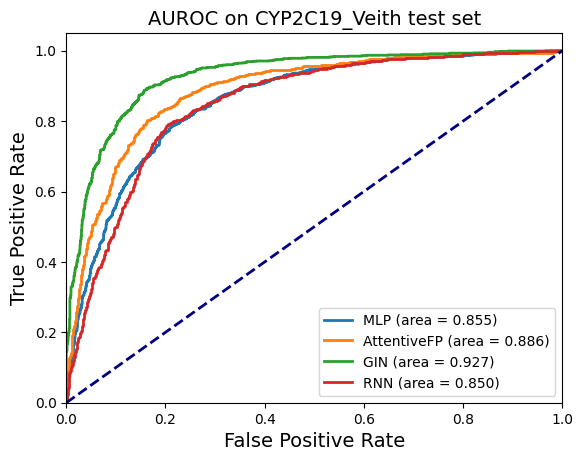

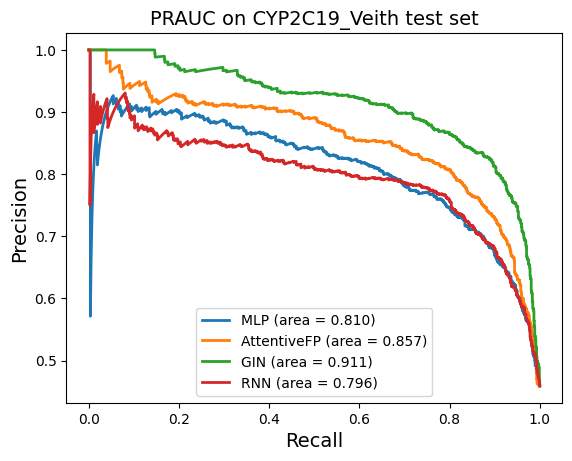

Found local copy...
Loading...
Done!


repeated num # 3 idx 1 has the lowest loss from [7.594187557697296, 7.512547075748444, 7.572348162531853]
******************** CYP2D6_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.858$\pm$0.001  &0.832$\pm$0.004  &0.624$\pm$0.008  
 idx 1: &0.857            &0.836            &0.634            

best model for CYP2D6_Veith, MLP: cls/CYP2D6_Veith/MLP_ST_1.yml
collect data for:  ['CYP2D6_Veith']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  cls/CYP2D6_Veith/MLP_ST_1.pt
[Test] Loss: 0.358
*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.857  &  0.717  &          0.653  &     0.494  &0.940  &0.562 &0.836 &   0.486 &   0.634


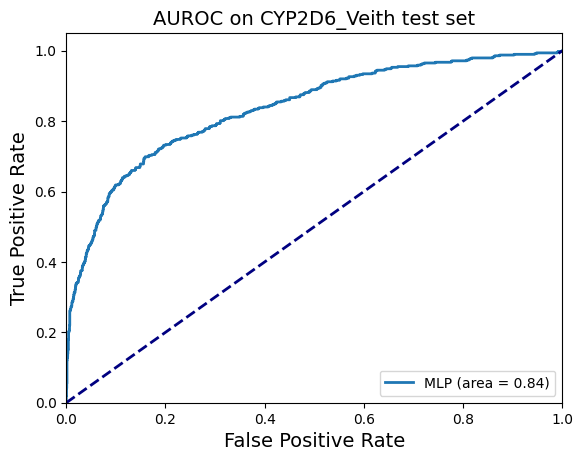

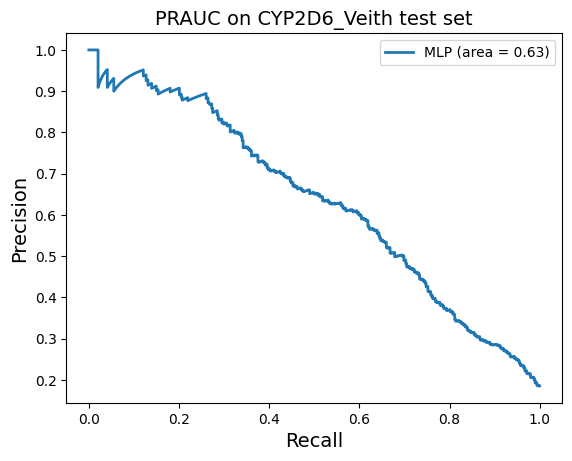

Found local copy...
Loading...
Done!



repeated num # 3 idx 0 has the lowest loss from [6.637383759021759, 6.796208471059799, 6.854156702756882]
******************** CYP2D6_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.884$\pm$0.001  &0.867$\pm$0.006  &0.698$\pm$0.015  
 idx 0: &0.885            &0.872            &0.704            

best model for CYP2D6_Veith, AttentiveFP: cls/CYP2D6_Veith/AttentiveFP_ST_0.yml
collect data for:  ['CYP2D6_Veith']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 1660 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 2623 out of 2626 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 2626 out of 2626 | elapsed:    3.4s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  cls/CYP2D6_Veith/AttentiveFP_ST_0.pt
[Test] Loss: 0.316
*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.885  &  0.754  &          0.771  &     0.545  &0.963  &0.639 &0.872 &   0.585 &   0.704


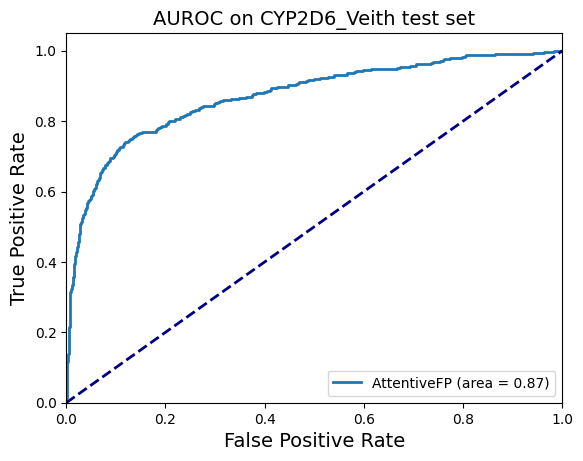

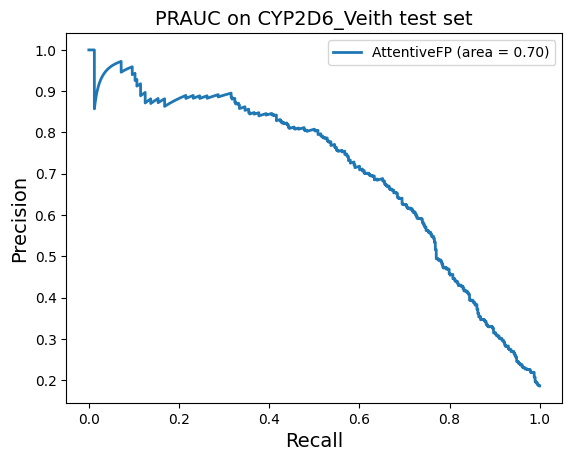

Found local copy...
Loading...
Done!



repeated num # 3 idx 0 has the lowest loss from [5.753726109862328, 5.795106813311577, 5.850933626294136]
******************** CYP2D6_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.890$\pm$0.003  &0.906$\pm$0.001  &0.761$\pm$0.002  
 idx 0: &0.892            &0.907            &0.764            

best model for CYP2D6_Veith, GIN: cls/CYP2D6_Veith/GIN_ST_0.yml
collect data for:  ['CYP2D6_Veith']
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  cls/CYP2D6_Veith/GIN_ST_0.pt
[Test] Loss: 0.274
*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.892  &  0.786  &          0.758  &     0.617  &0.955  &0.680 &0.907 &   0.621 &   0.764


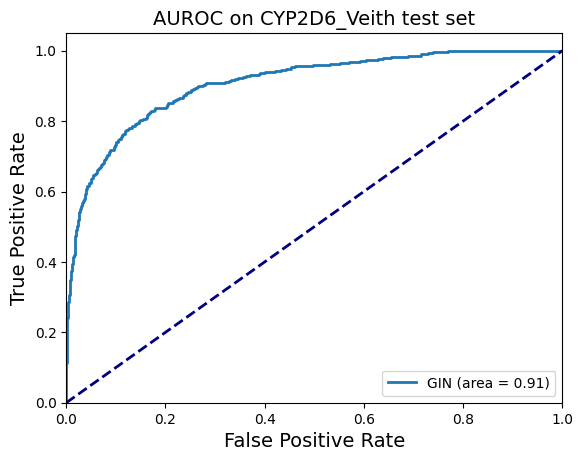

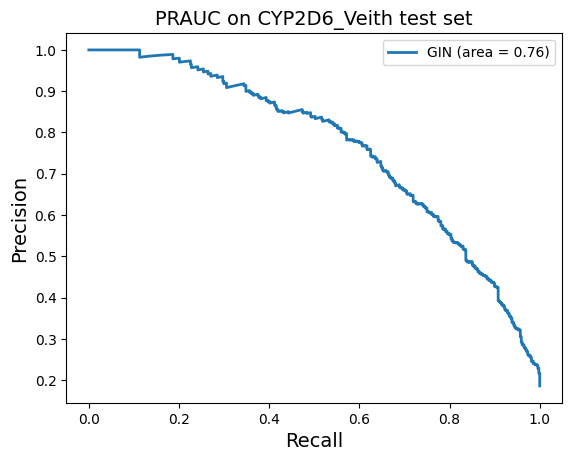

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [8.05085802078247, 8.002246707677841, 8.279567688703537]
******************** CYP2D6_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.845$\pm$0.002  &0.802$\pm$0.002  &0.549$\pm$0.010  
 idx 1: &0.848            &0.803            &0.555            

best model for CYP2D6_Veith, RNN: cls/CYP2D6_Veith/RNN_ST_1.yml
collect data for:  ['CYP2D6_Veith']
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  cls/CYP2D6_Veith/RNN_ST_1.pt
[Test] Loss: 0.381
*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.848  &  0.672  &          0.650  &     0.391  &0.952  &0.488 &0.803 &   0.423 &   0.555


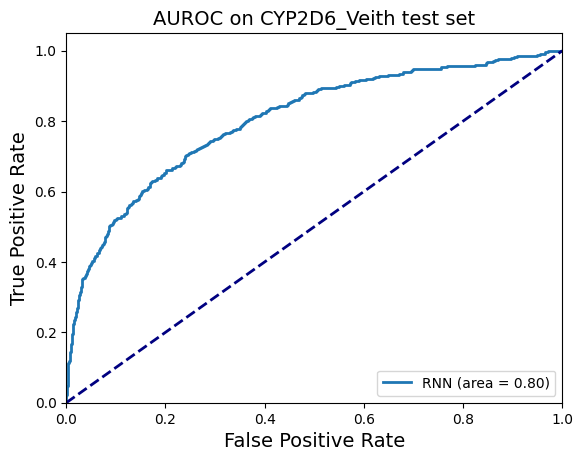

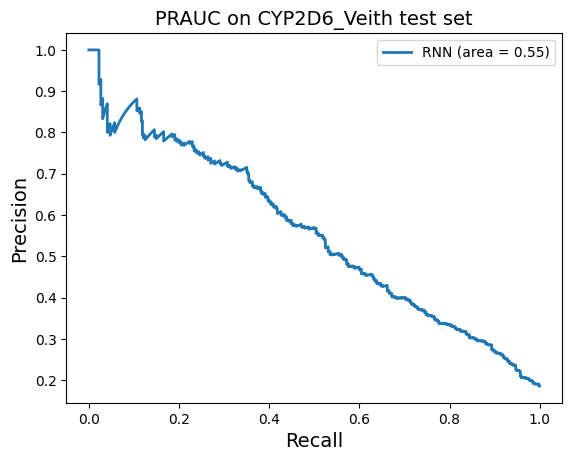

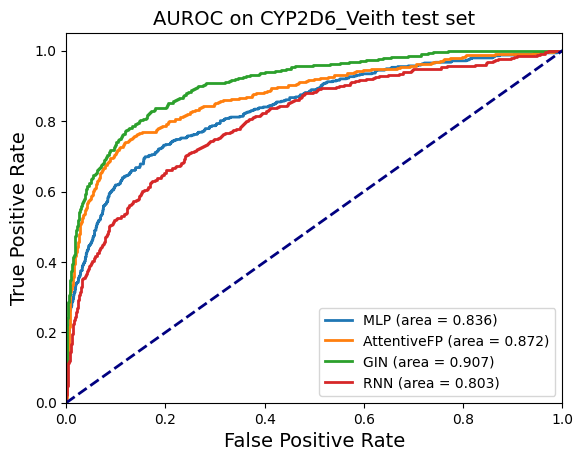

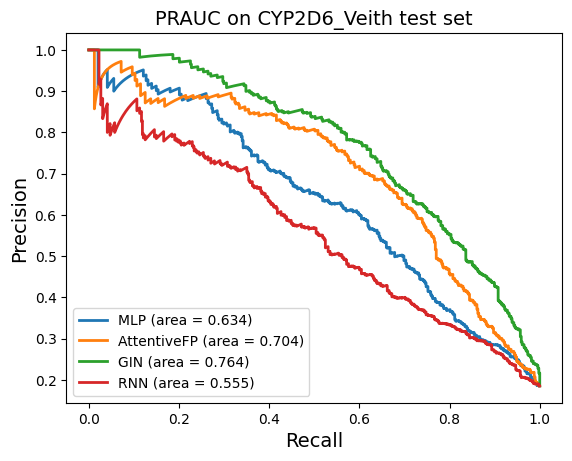

Found local copy...
Loading...
Done!


repeated num # 3 idx 2 has the lowest loss from [9.90074297785759, 9.75652265548706, 9.706116318702698]
******************** CYP3A4_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.770$\pm$0.001  &0.845$\pm$0.002  &0.784$\pm$0.001  
 idx 2: &0.770            &0.847            &0.784            

best model for CYP3A4_Veith, MLP: cls/CYP3A4_Veith/MLP_ST_2.yml
collect data for:  ['CYP3A4_Veith']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  cls/CYP3A4_Veith/MLP_ST_2.pt
[Test] Loss: 0.485
*************** CYP3A4_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.770  &  0.767  &          0.710  &     0.748  &0.785  &0.729 &0.847 &   0.530 &   0.784


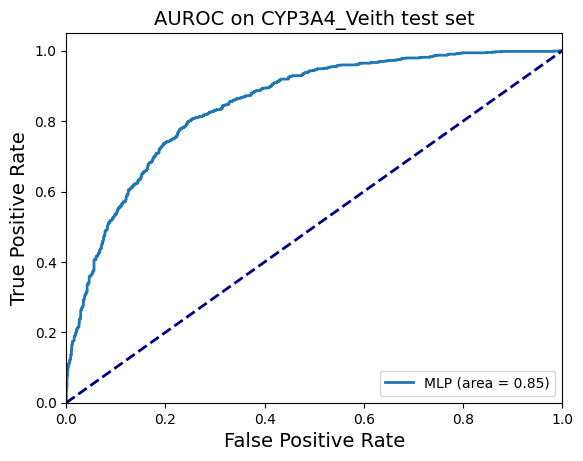

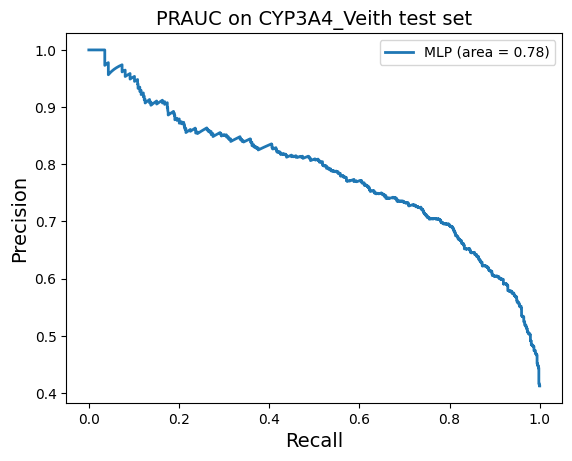

Found local copy...
Loading...
Done!



repeated num # 3 idx 0 has the lowest loss from [8.258456617593765, 8.405469089746475, 8.367070645093918]
******************** CYP3A4_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.808$\pm$0.002  &0.893$\pm$0.002  &0.848$\pm$0.003  
 idx 0: &0.810            &0.895            &0.852            

best model for CYP3A4_Veith, AttentiveFP: cls/CYP3A4_Veith/AttentiveFP_ST_0.yml
collect data for:  ['CYP3A4_Veith']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 1660 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 2466 out of 2466 | elapsed:    3.4s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  cls/CYP3A4_Veith/AttentiveFP_ST_0.pt
[Test] Loss: 0.413
*************** CYP3A4_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.810  &  0.803  &          0.775  &     0.760  &0.845  &0.768 &0.895 &   0.607 &   0.852


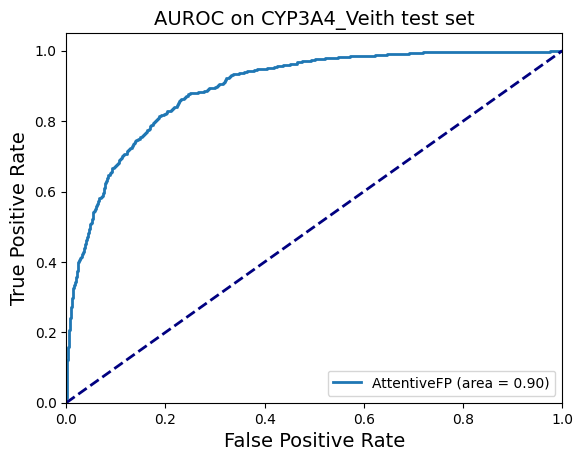

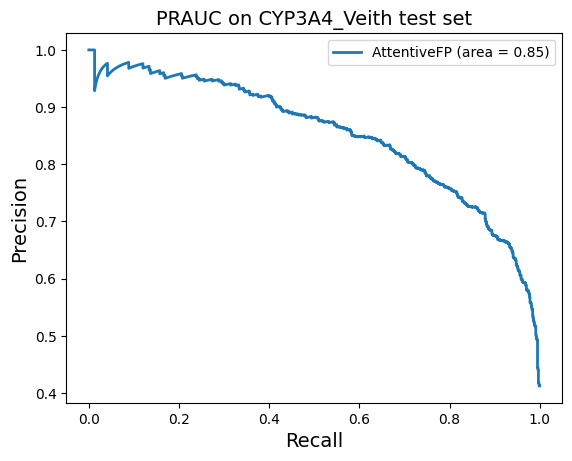

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [7.254241466522217, 7.225134432315826, 7.180712997913361]
******************** CYP3A4_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.845$\pm$0.001  &0.921$\pm$0.001  &0.888$\pm$0.001  
 idx 2: &0.845            &0.922            &0.889            

best model for CYP3A4_Veith, GIN: cls/CYP3A4_Veith/GIN_ST_2.yml
collect data for:  ['CYP3A4_Veith']
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  cls/CYP3A4_Veith/GIN_ST_2.pt
[Test] Loss: 0.359
*************** CYP3A4_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.845  &  0.840  &          0.809  &     0.816  &0.865  &0.813 &0.922 &   0.680 &   0.889


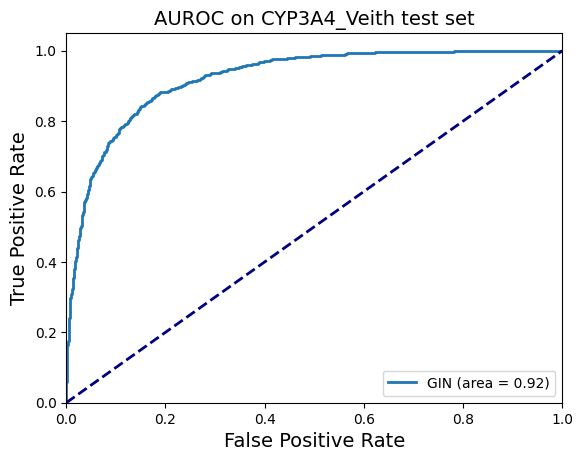

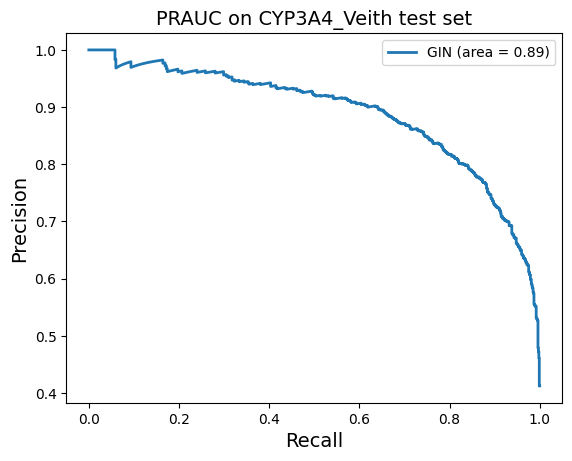

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [10.07848846912384, 10.074375838041306, 10.030691623687744]
******************** CYP3A4_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.745$\pm$0.003  &0.830$\pm$0.000  &0.759$\pm$0.007  
 idx 2: &0.741            &0.830            &0.767            

best model for CYP3A4_Veith, RNN: cls/CYP3A4_Veith/RNN_ST_2.yml
collect data for:  ['CYP3A4_Veith']
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  cls/CYP3A4_Veith/RNN_ST_2.pt
[Test] Loss: 0.502
*************** CYP3A4_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.741  &  0.717  &          0.734  &     0.582  &0.852  &0.649 &0.830 &   0.456 &   0.767


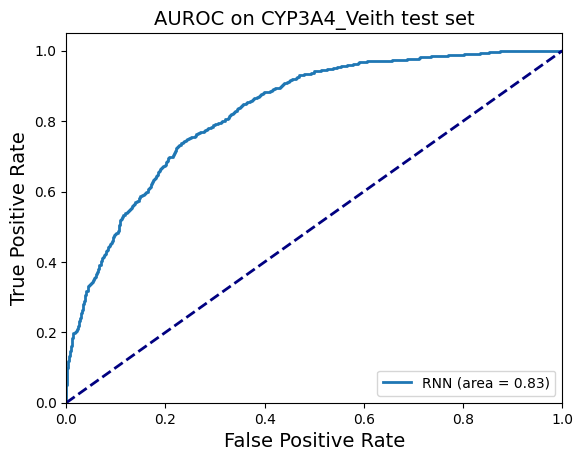

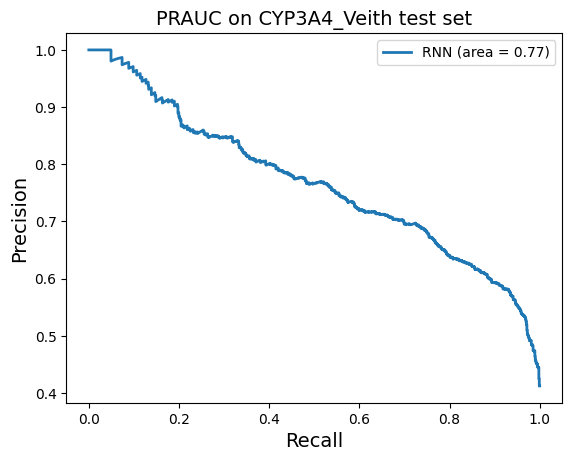

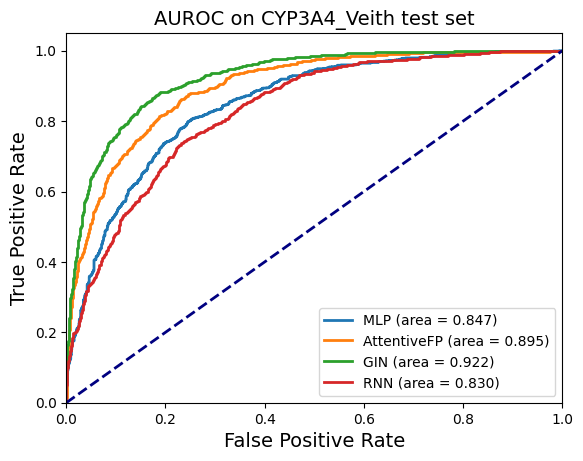

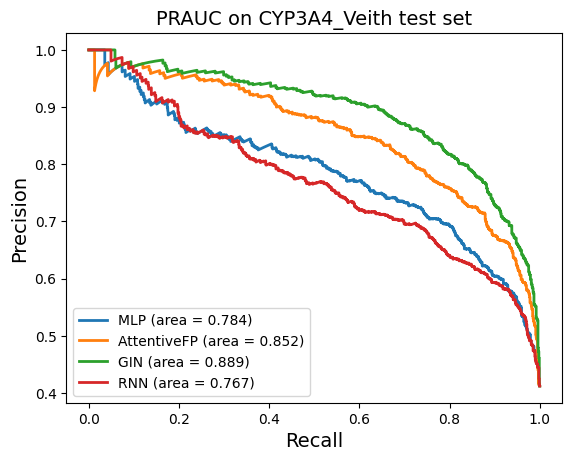

Found local copy...
Loading...
Done!


repeated num # 3 idx 1 has the lowest loss from [7.977181255817413, 7.828005403280258, 7.93458753824234]
******************** CYP1A2_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.825$\pm$0.004  &0.903$\pm$0.001  &0.888$\pm$0.001  
 idx 1: &0.831            &0.904            &0.890            

best model for CYP1A2_Veith, MLP: cls/CYP1A2_Veith/MLP_ST_1.yml
collect data for:  ['CYP1A2_Veith']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  cls/CYP1A2_Veith/MLP_ST_1.pt
[Test] Loss: 0.391
*************** CYP1A2_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.831  &  0.830  &          0.825  &     0.816  &0.845  &0.820 &0.904 &   0.661 &   0.890


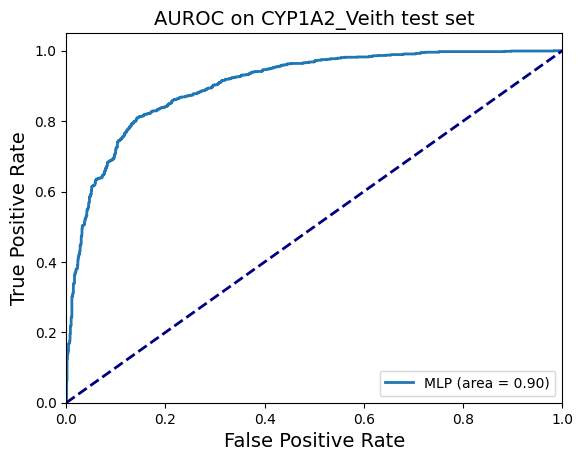

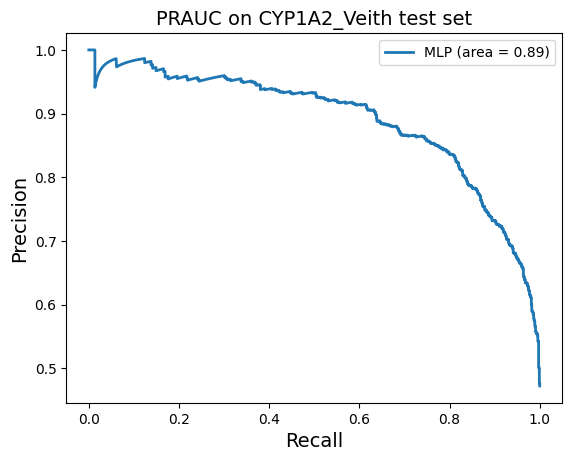

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [6.637626349925995, 6.586922332644463, 6.544988766312599]
******************** CYP1A2_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.865$\pm$0.004  &0.937$\pm$0.001  &0.931$\pm$0.001  
 idx 2: &0.861            &0.938            &0.932            

best model for CYP1A2_Veith, AttentiveFP: cls/CYP1A2_Veith/AttentiveFP_ST_2.yml
collect data for:  ['CYP1A2_Veith']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 1660 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done 2516 out of 2516 | elapsed:    3.3s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  cls/CYP1A2_Veith/AttentiveFP_ST_2.pt
[Test] Loss: 0.327
*************** CYP1A2_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.861  &  0.862  &          0.839  &     0.874  &0.850  &0.856 &0.938 &   0.723 &   0.932


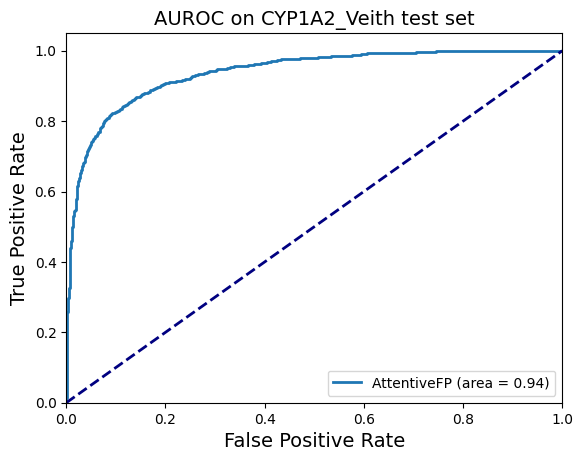

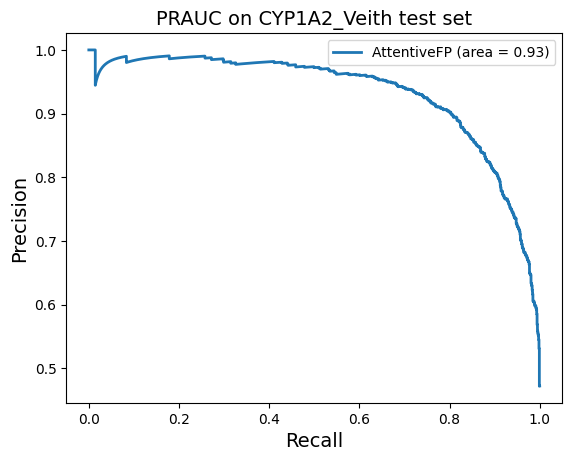

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [5.9461245238780975, 5.814434617757797, 5.841835916042328]
******************** CYP1A2_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.878$\pm$0.001  &0.949$\pm$0.001  &0.945$\pm$0.001  
 idx 1: &0.877            &0.949            &0.945            

best model for CYP1A2_Veith, GIN: cls/CYP1A2_Veith/GIN_ST_1.yml
collect data for:  ['CYP1A2_Veith']
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  cls/CYP1A2_Veith/GIN_ST_1.pt
[Test] Loss: 0.291
*************** CYP1A2_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.877  &  0.876  &          0.875  &     0.863  &0.889  &0.869 &0.949 &   0.753 &   0.945


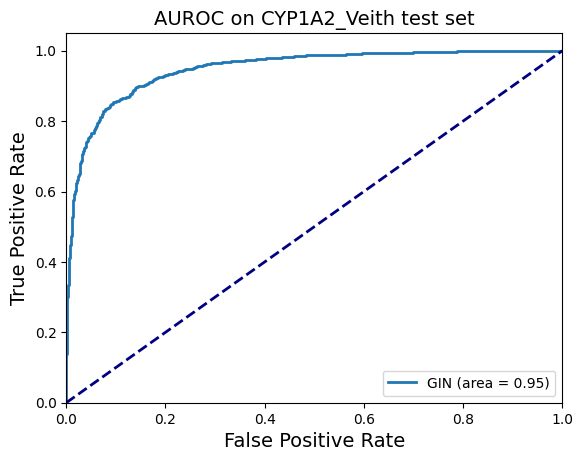

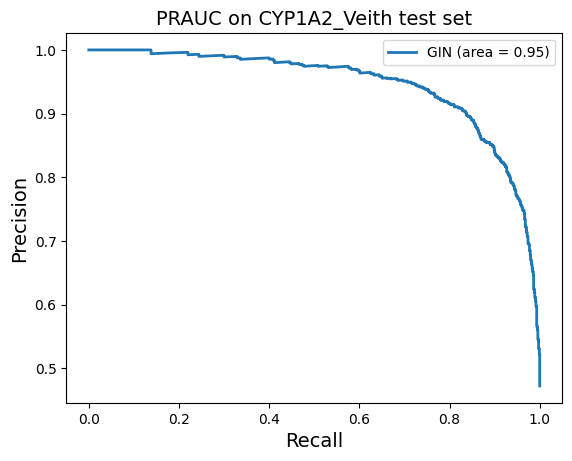

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [7.807887077331543, 7.768774449825287, 8.041907608509064]
******************** CYP1A2_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.821$\pm$0.007  &0.905$\pm$0.002  &0.894$\pm$0.001  
 idx 1: &0.823            &0.906            &0.895            

best model for CYP1A2_Veith, RNN: cls/CYP1A2_Veith/RNN_ST_1.yml
collect data for:  ['CYP1A2_Veith']
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  cls/CYP1A2_Veith/RNN_ST_1.pt
[Test] Loss: 0.388
*************** CYP1A2_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.823  &  0.822  &          0.819  &     0.803  &0.841  &0.811 &0.906 &   0.645 &   0.895


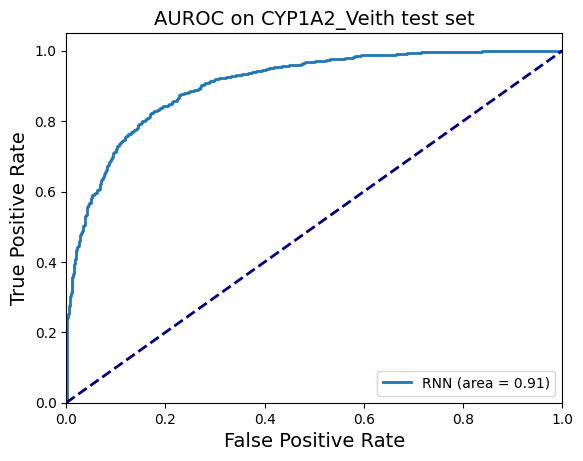

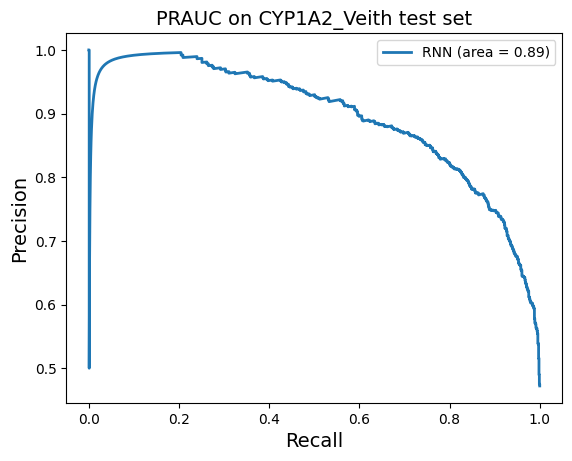

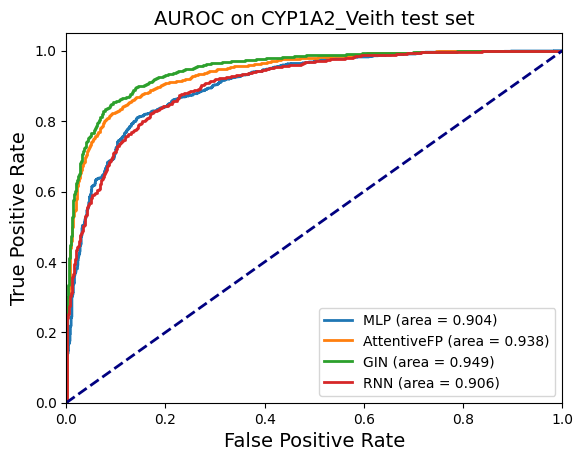

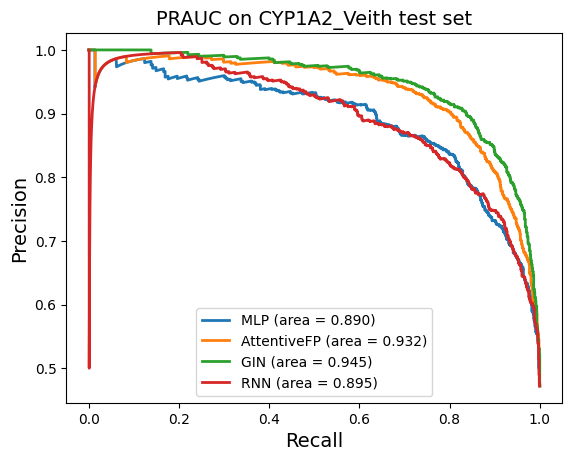

Found local copy...
Loading...
Done!


repeated num # 3 idx 0 has the lowest loss from [8.205730676651001, 8.260850697755814, 8.282487779855728]
******************** CYP2C9_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.799$\pm$0.005  &0.864$\pm$0.001  &0.726$\pm$0.004  
 idx 0: &0.806            &0.866            &0.731            

best model for CYP2C9_Veith, MLP: cls/CYP2C9_Veith/MLP_ST_0.yml
collect data for:  ['CYP2C9_Veith']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  cls/CYP2C9_Veith/MLP_ST_0.pt
[Test] Loss: 0.432
*************** CYP2C9_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.806  &  0.783  &          0.713  &     0.714  &0.852  &0.713 &0.866 &   0.566 &   0.731


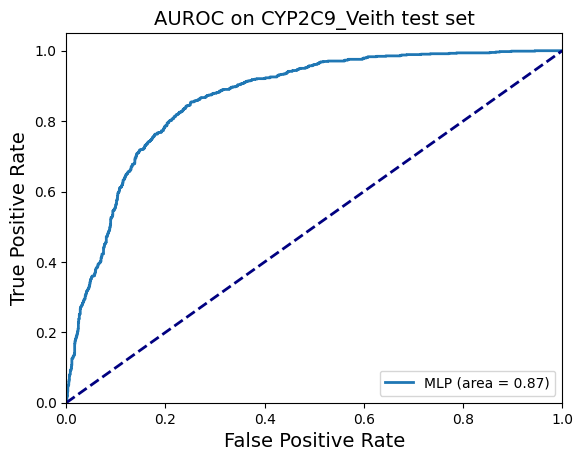

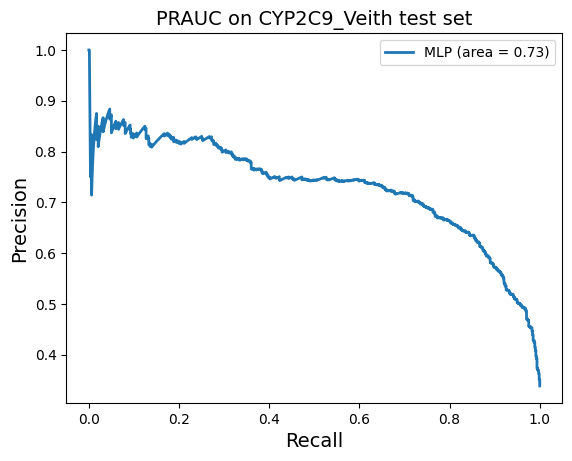

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [7.554665684700012, 7.456499308347702, 7.560906946659088]
******************** CYP2C9_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.830$\pm$0.002  &0.894$\pm$0.002  &0.787$\pm$0.006  
 idx 1: &0.833            &0.896            &0.791            

best model for CYP2C9_Veith, AttentiveFP: cls/CYP2C9_Veith/AttentiveFP_ST_1.yml
collect data for:  ['CYP2C9_Veith']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 1660 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 2415 out of 2418 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 2418 out of 2418 | elapsed:    3.3s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  cls/CYP2C9_Veith/AttentiveFP_ST_1.pt
[Test] Loss: 0.392
*************** CYP2C9_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.833  &  0.825  &          0.733  &     0.800  &0.851  &0.765 &0.896 &   0.638 &   0.791


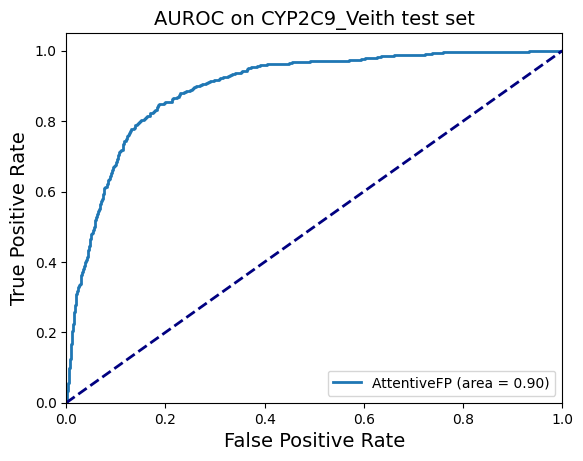

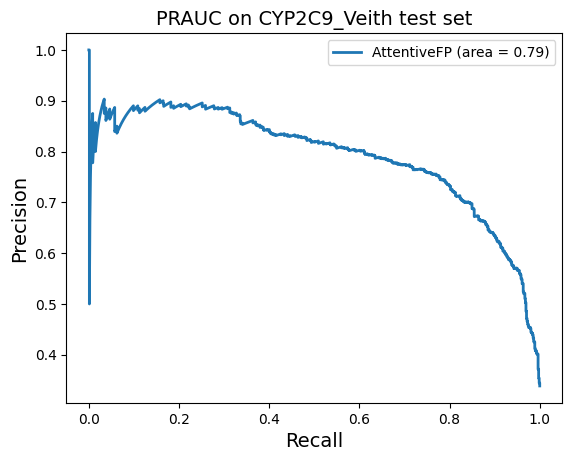

Found local copy...
Loading...
Done!



repeated num # 3 idx 0 has the lowest loss from [5.76018263399601, 5.812062785029411, 5.831666201353073]
******************** CYP2C9_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.869$\pm$0.001  &0.937$\pm$0.001  &0.871$\pm$0.002  
 idx 0: &0.870            &0.938            &0.873            

best model for CYP2C9_Veith, GIN: cls/CYP2C9_Veith/GIN_ST_0.yml
collect data for:  ['CYP2C9_Veith']
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  cls/CYP2C9_Veith/GIN_ST_0.pt
[Test] Loss: 0.303
*************** CYP2C9_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.870  &  0.857  &          0.804  &     0.816  &0.898  &0.810 &0.938 &   0.711 &   0.873


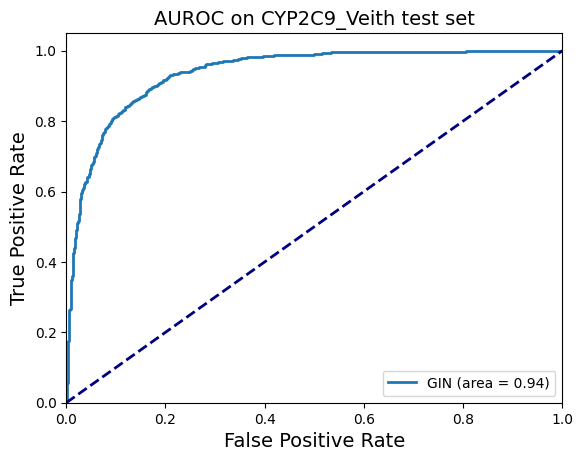

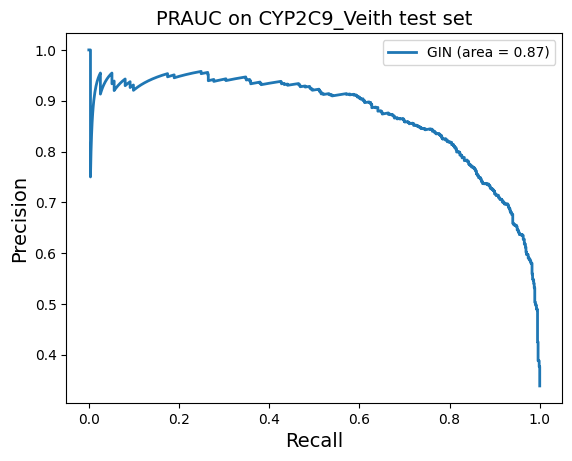

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [8.521400570869446, 8.2323257625103, 8.432726472616196]
******************** CYP2C9_Veith ******************** 
	|       acc      |       auc      |       ap      
	&0.797$\pm$0.003  &0.862$\pm$0.003  &0.739$\pm$0.005  
 idx 1: &0.798            &0.866            &0.745            

best model for CYP2C9_Veith, RNN: cls/CYP2C9_Veith/RNN_ST_1.yml
collect data for:  ['CYP2C9_Veith']
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  cls/CYP2C9_Veith/RNN_ST_1.pt
[Test] Loss: 0.433
*************** CYP2C9_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.798  &  0.768  &          0.712  &     0.678  &0.859  &0.694 &0.866 &   0.544 &   0.745


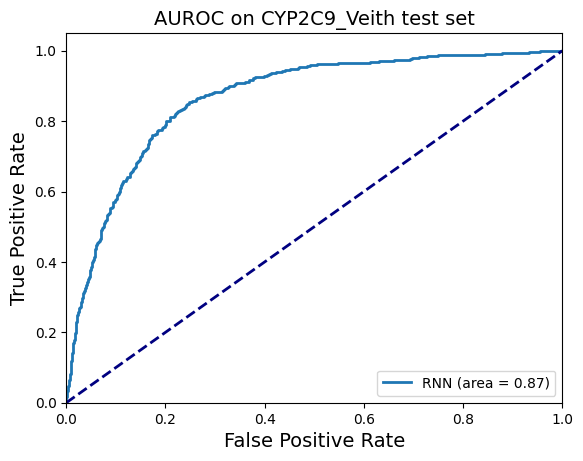

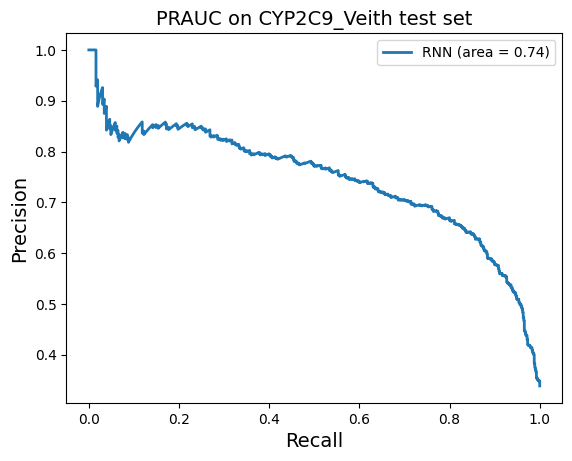

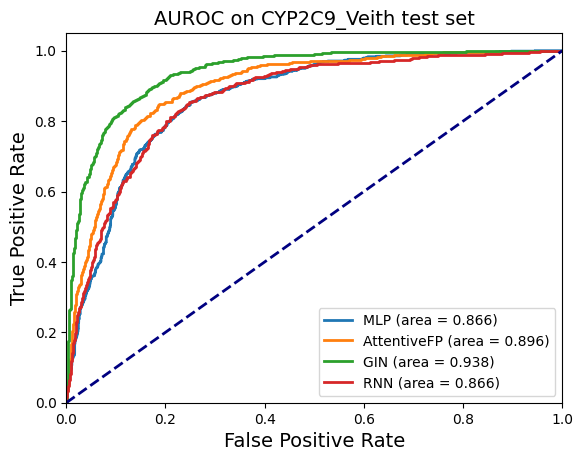

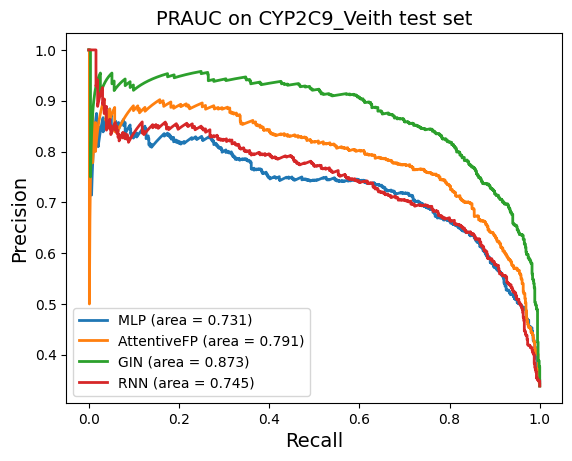

Found local copy...
Loading...
Done!


repeated num # 3 idx 1 has the lowest loss from [1.3977927565574646, 1.3694045692682266, 1.3694694936275482]
******************** BBB_Martins ******************** 
	|       acc      |       auc      |       ap      
	&0.849$\pm$0.001  &0.875$\pm$0.004  &0.946$\pm$0.002  
 idx 1: &0.850            &0.876            &0.948            

best model for BBB_Martins, MLP: cls/BBB_Martins/MLP_ST_1.yml
collect data for:  ['BBB_Martins']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  cls/BBB_Martins/MLP_ST_1.pt
[Test] Loss: 0.342
*************** BBB_Martins ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.850  &  0.749  &          0.860  &     0.954  &0.544  &0.905 &0.876 &   0.573 &   0.948


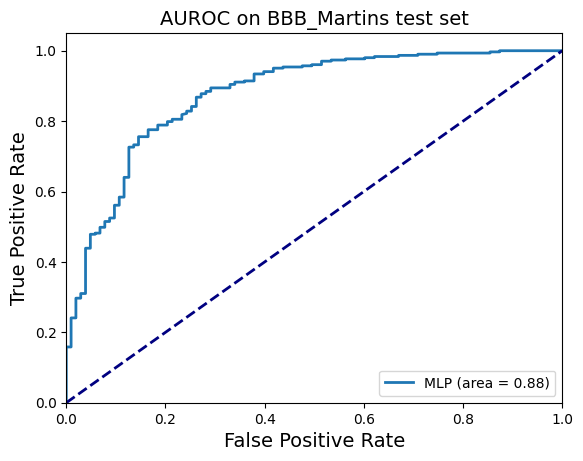

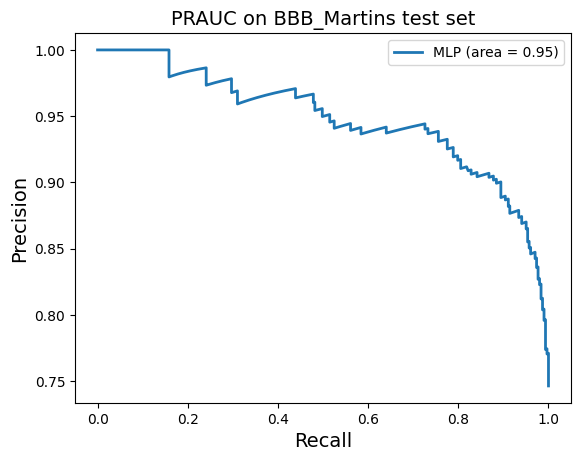

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [0.5945599675178528, 0.5880054235458374, 0.6139145791530609]
******************** BBB_Martins ******************** 
	|       acc      |       auc      |       ap      
	&0.878$\pm$0.008  &0.892$\pm$0.007  &0.944$\pm$0.003  
 idx 1: &0.867            &0.901            &0.948            

best model for BBB_Martins, AttentiveFP: cls/BBB_Martins/AttentiveFP_ST_1.yml
collect data for:  ['BBB_Martins']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 400 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 406 out of 406 | elapsed:    0.6s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  cls/BBB_Martins/AttentiveFP_ST_1.pt
[Test] Loss: 0.373
*************** BBB_Martins ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.850  &  0.758  &          0.867  &     0.944  &0.573  &0.904 &0.865 &   0.576 &   0.932


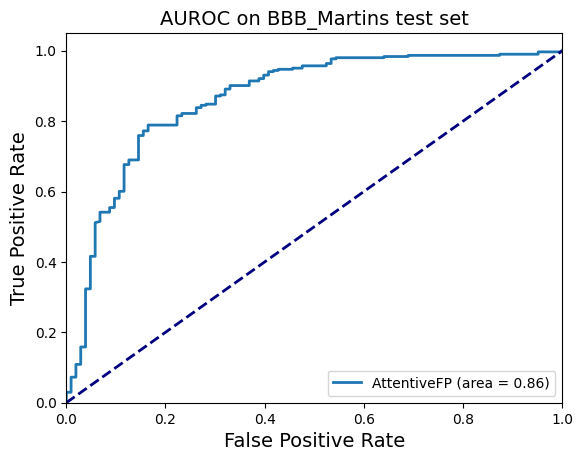

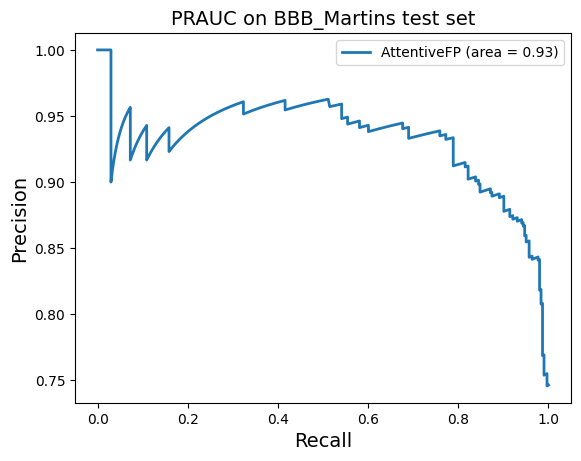

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [1.238070785999298, 1.205044373869896, 1.2442123591899872]
******************** BBB_Martins ******************** 
	|       acc      |       auc      |       ap      
	&0.863$\pm$0.002  &0.913$\pm$0.003  &0.966$\pm$0.001  
 idx 1: &0.860            &0.914            &0.966            

best model for BBB_Martins, GIN: cls/BBB_Martins/GIN_ST_1.yml
collect data for:  ['BBB_Martins']
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  cls/BBB_Martins/GIN_ST_1.pt
[Test] Loss: 0.301
*************** BBB_Martins ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.860  &  0.781  &          0.880  &     0.941  &0.621  &0.909 &0.914 &   0.609 &   0.966


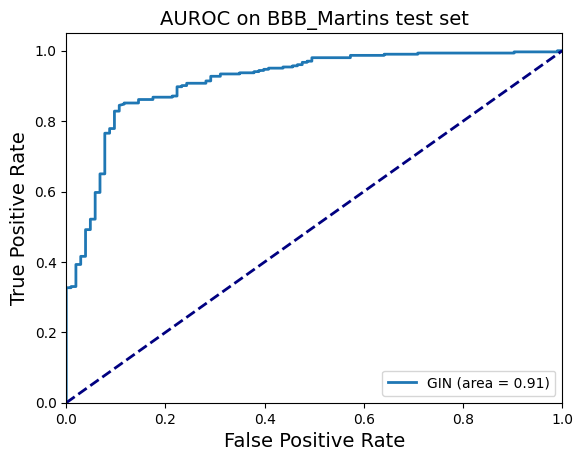

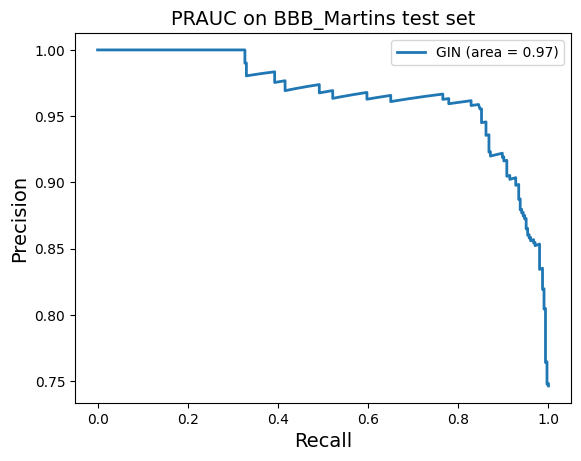

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [1.5305130779743195, 1.5076239258050919, 1.5274814069271088]
******************** BBB_Martins ******************** 
	|       acc      |       auc      |       ap      
	&0.833$\pm$0.002  &0.844$\pm$0.008  &0.930$\pm$0.007  
 idx 1: &0.835            &0.854            &0.938            

best model for BBB_Martins, RNN: cls/BBB_Martins/RNN_ST_1.yml
collect data for:  ['BBB_Martins']
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  cls/BBB_Martins/RNN_ST_1.pt
[Test] Loss: 0.377
*************** BBB_Martins ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.835  &  0.720  &          0.845  &     0.954  &0.485  &0.896 &0.854 &   0.524 &   0.938


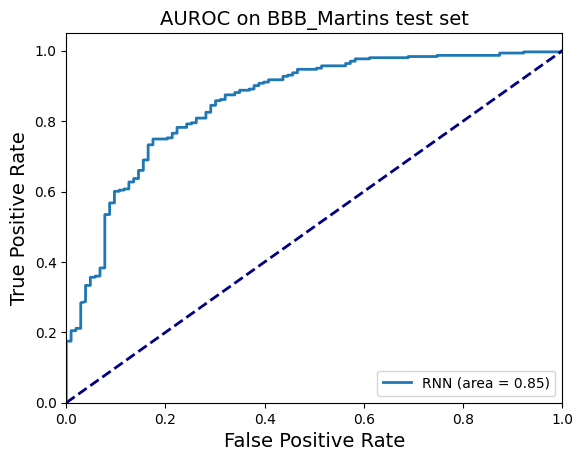

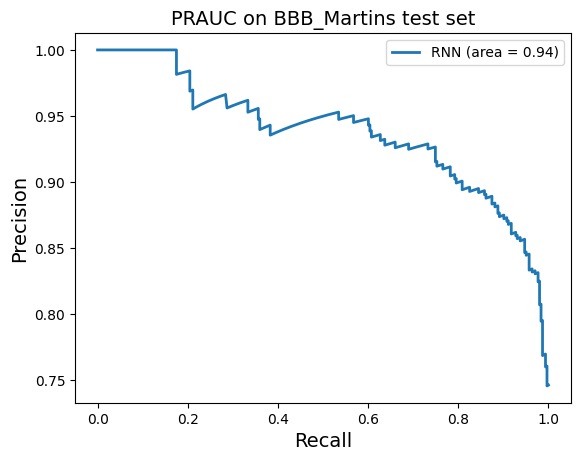

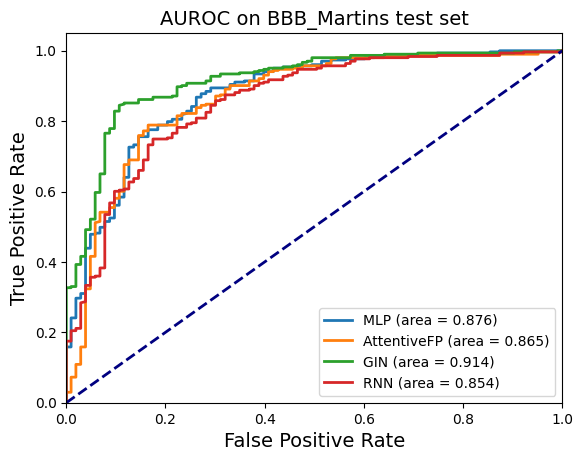

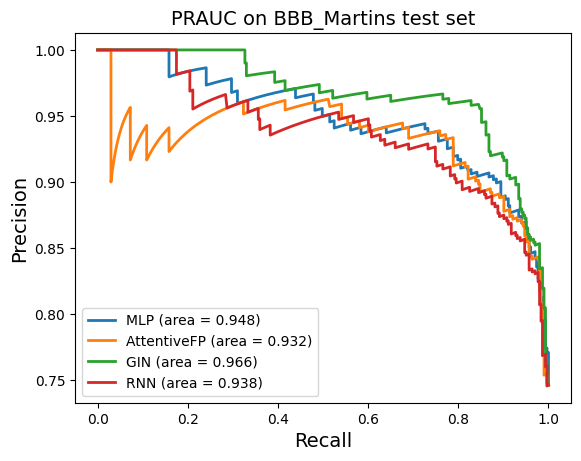

Found local copy...
Loading...
Done!


repeated num # 3 idx 2 has the lowest loss from [0.6337006092071533, 0.6266316175460815, 0.6225000619888306]
******************** Bioavailability_Ma ******************** 
	|       acc      |       auc      |       ap      
	&0.716$\pm$0.010  &0.676$\pm$0.008  &0.794$\pm$0.007  
 idx 2: &0.719            &0.665            &0.784            

best model for Bioavailability_Ma, MLP: cls/Bioavailability_Ma/MLP_ST_2.yml
collect data for:  ['Bioavailability_Ma']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  cls/Bioavailability_Ma/MLP_ST_2.pt
[Test] Loss: 0.623
*************** Bioavailability_Ma ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.719  &  0.564  &          0.733  &     0.944  &0.184  &0.825 &0.665 &   0.202 &   0.784


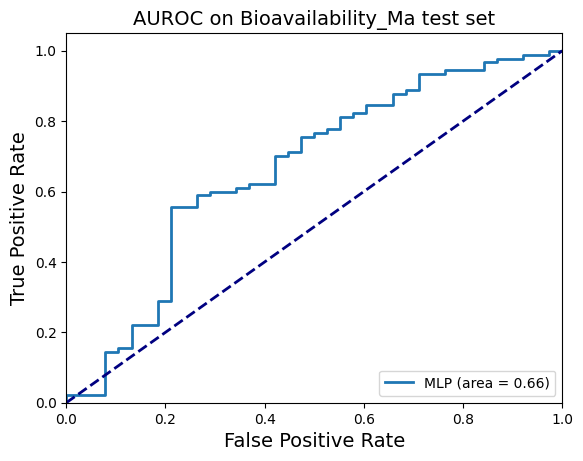

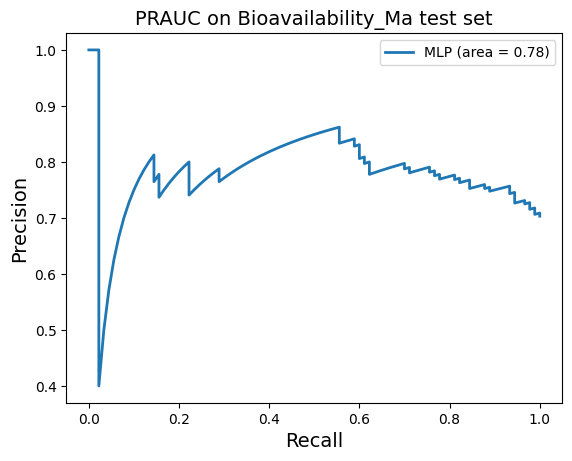

Found local copy...
Loading...
Done!



repeated num # 3 idx 0 has the lowest loss from [0.5755605697631836, 0.5865597128868103, 0.5963247418403625]
******************** Bioavailability_Ma ******************** 
	|       acc      |       auc      |       ap      
	&0.721$\pm$0.019  &0.698$\pm$0.022  &0.846$\pm$0.023  
 idx 0: &0.742            &0.727            &0.875            

best model for Bioavailability_Ma, AttentiveFP: cls/Bioavailability_Ma/AttentiveFP_ST_0.yml
collect data for:  ['Bioavailability_Ma']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 128 out of 128 | elapsed:    0.2s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  cls/Bioavailability_Ma/AttentiveFP_ST_0.pt
[Test] Loss: 0.576
*************** Bioavailability_Ma ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.742  &  0.589  &          0.744  &     0.967  &0.211  &0.841 &0.727 &   0.289 &   0.875


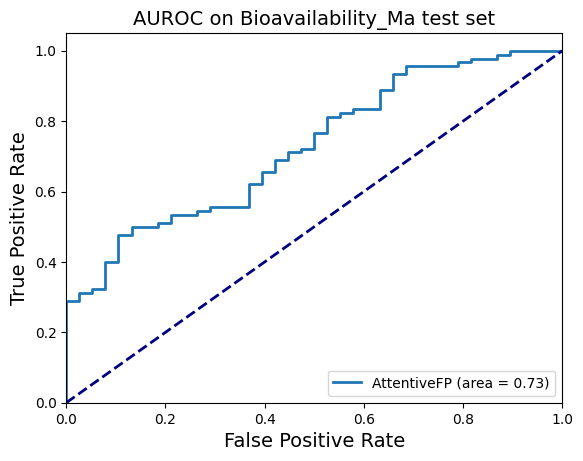

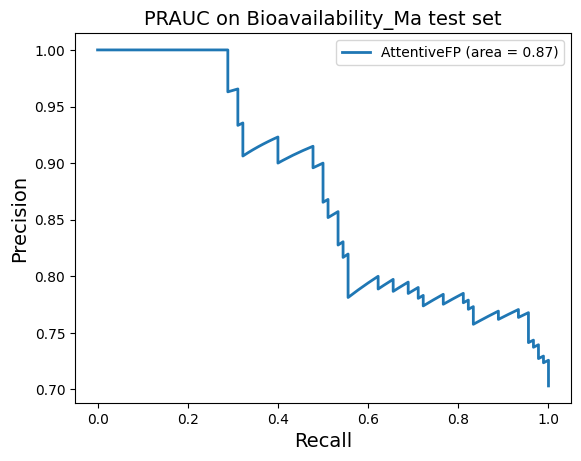

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [0.6256119012832642, 0.6172922849655151, 0.607697069644928]
******************** Bioavailability_Ma ******************** 
	|       acc      |       auc      |       ap      
	&0.706$\pm$0.004  &0.661$\pm$0.004  &0.803$\pm$0.005  
 idx 2: &0.703            &0.665            &0.807            

best model for Bioavailability_Ma, GIN: cls/Bioavailability_Ma/GIN_ST_2.yml
collect data for:  ['Bioavailability_Ma']
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  cls/Bioavailability_Ma/GIN_ST_2.pt
[Test] Loss: 0.608
*************** Bioavailability_Ma ***************
at least 2 of TP, FP, TN, FN are 0, cannot cal MCC, set as -100
TP, FP, TN, FN 90 38 0 0
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.703  &  0.500  &          0.703  &     1.000  &0.000  &0.8

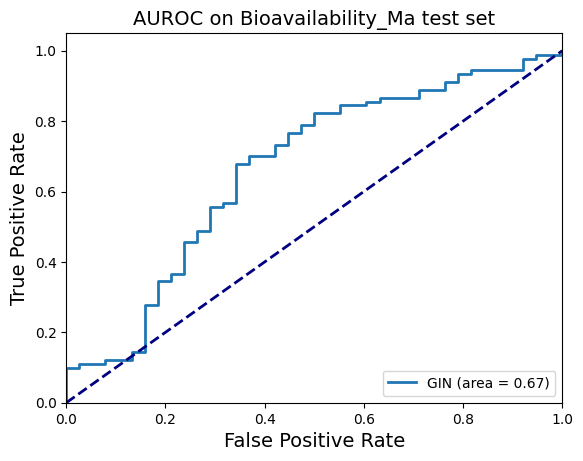

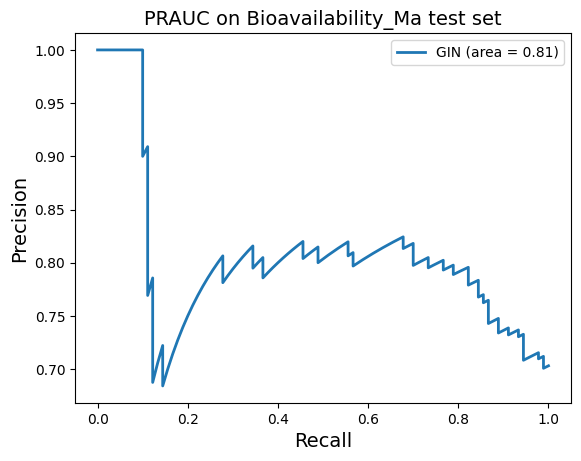

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [0.6523380279541016, 0.6315628290176392, 0.6286265254020691]
******************** Bioavailability_Ma ******************** 
	|       acc      |       auc      |       ap      
	&0.714$\pm$0.004  &0.625$\pm$0.014  &0.799$\pm$0.003  
 idx 2: &0.719            &0.634            &0.796            

best model for Bioavailability_Ma, RNN: cls/Bioavailability_Ma/RNN_ST_2.yml
collect data for:  ['Bioavailability_Ma']
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  cls/Bioavailability_Ma/RNN_ST_2.pt
[Test] Loss: 0.629
*************** Bioavailability_Ma ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.719  &  0.557  &          0.729  &     0.956  &0.158  &0.827 &0.634 &   0.193 &   0.796


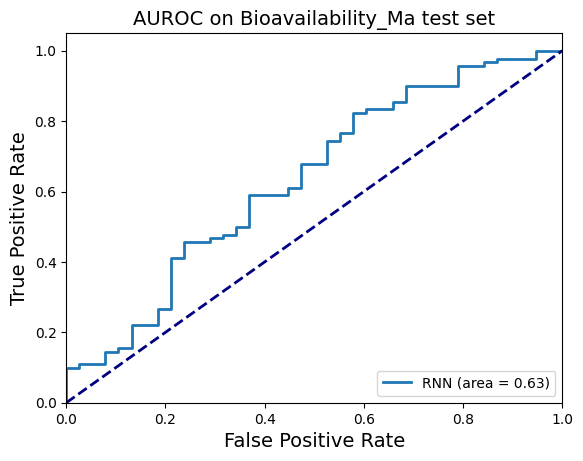

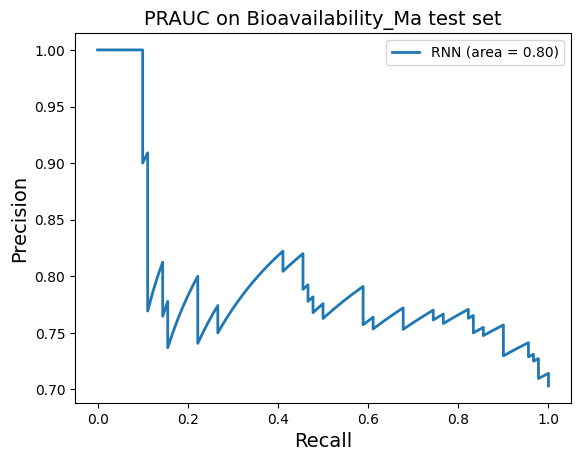

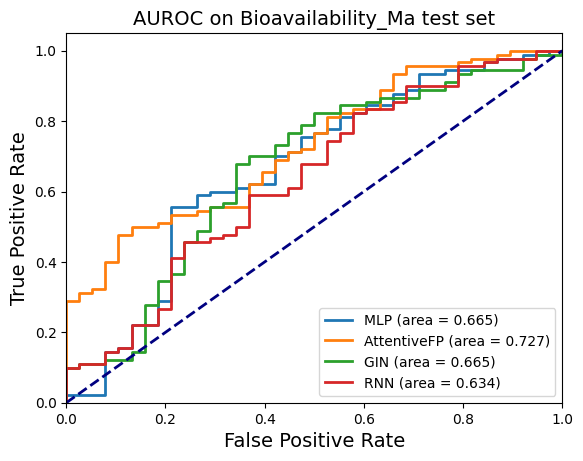

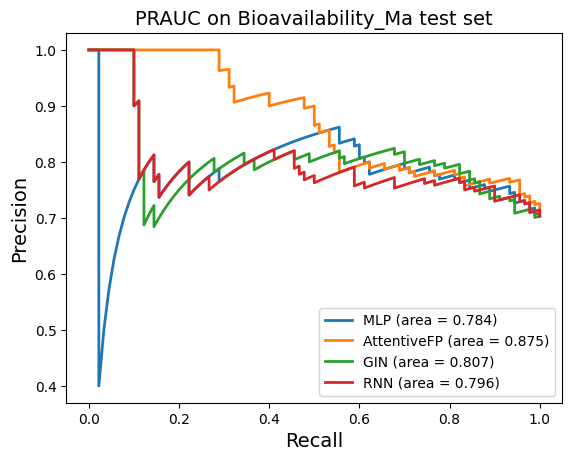

Found local copy...
Loading...
Done!


repeated num # 3 idx 2 has the lowest loss from [1.0510520935058594, 0.9446919858455658, 0.910111278295517]
******************** Pgp_Broccatelli ******************** 
	|       acc      |       auc      |       ap      
	&0.798$\pm$0.005  &0.870$\pm$0.004  &0.899$\pm$0.005  
 idx 2: &0.791            &0.873            &0.904            

best model for Pgp_Broccatelli, MLP: cls/Pgp_Broccatelli/MLP_ST_2.yml
collect data for:  ['Pgp_Broccatelli']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  cls/Pgp_Broccatelli/MLP_ST_2.pt
[Test] Loss: 0.455
*************** Pgp_Broccatelli ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.791  &  0.791  &          0.781  &     0.813  &0.769  &0.797 &0.873 &   0.582 &   0.904


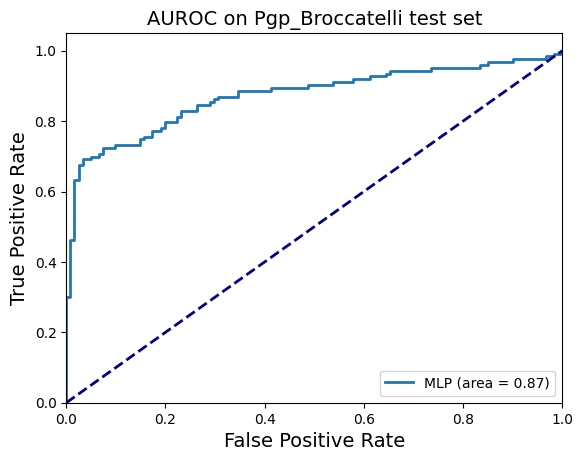

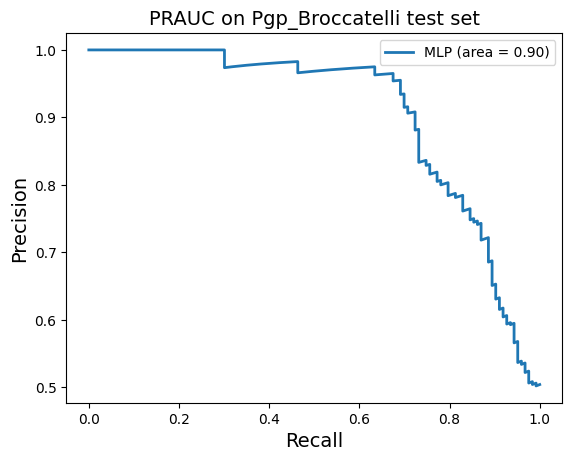

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [0.39104339480400085, 0.38798660039901733, 0.3848778009414673]
******************** Pgp_Broccatelli ******************** 
	|       acc      |       auc      |       ap      
	&0.842$\pm$0.008  &0.908$\pm$0.003  &0.926$\pm$0.002  
 idx 2: &0.836            &0.911            &0.929            

best model for Pgp_Broccatelli, AttentiveFP: cls/Pgp_Broccatelli/AttentiveFP_ST_2.yml
collect data for:  ['Pgp_Broccatelli']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 236 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 244 out of 244 | elapsed:    0.3s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  cls/Pgp_Broccatelli/AttentiveFP_ST_2.pt
[Test] Loss: 0.417
*************** Pgp_Broccatelli ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.848  &  0.848  &          0.821  &     0.894  &0.802  &0.856 &0.905 &   0.699 &   0.911


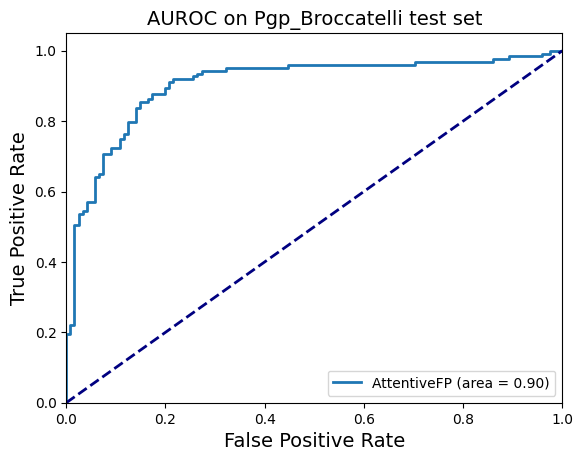

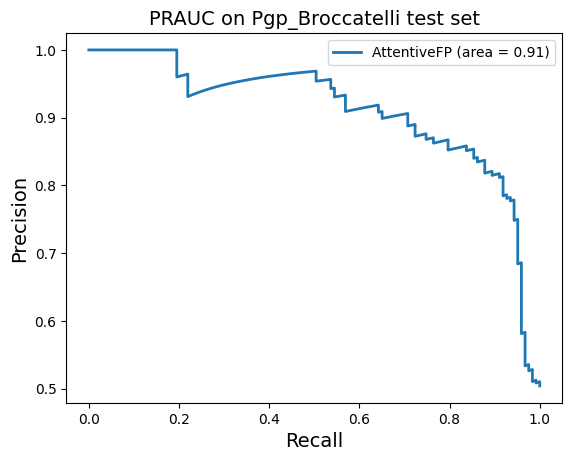

Found local copy...
Loading...
Done!



repeated num # 3 idx 0 has the lowest loss from [1.0665206909179688, 1.1509209275245667, 1.2107048630714417]
******************** Pgp_Broccatelli ******************** 
	|       acc      |       auc      |       ap      
	&0.816$\pm$0.003  &0.884$\pm$0.001  &0.905$\pm$0.001  
 idx 0: &0.820            &0.882            &0.904            

best model for Pgp_Broccatelli, GIN: cls/Pgp_Broccatelli/GIN_ST_0.yml
collect data for:  ['Pgp_Broccatelli']
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  cls/Pgp_Broccatelli/GIN_ST_0.pt
[Test] Loss: 0.533
*************** Pgp_Broccatelli ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.820  &  0.820  &          0.832  &     0.805  &0.835  &0.818 &0.882 &   0.640 &   0.904


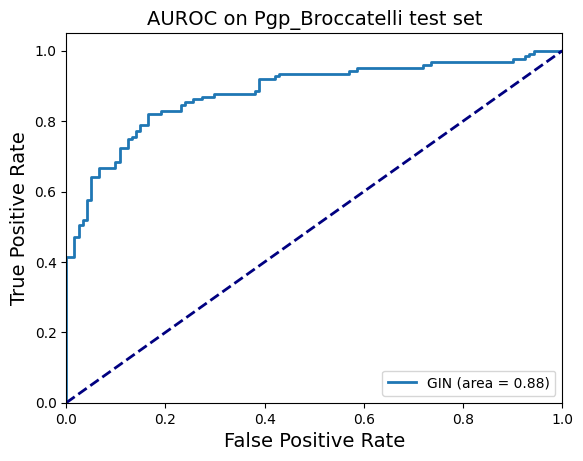

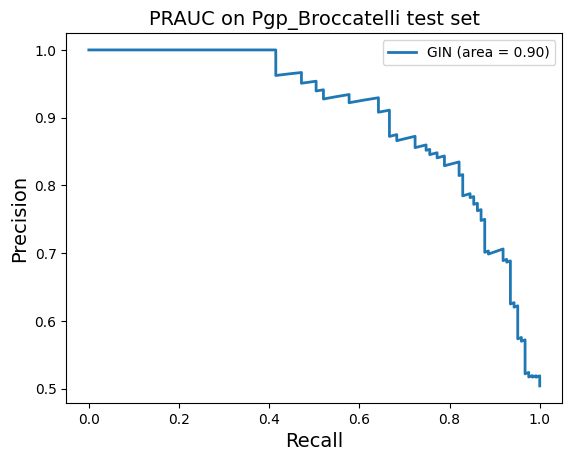

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [0.8047928810119629, 0.802126944065094, 0.8314682245254517]
******************** Pgp_Broccatelli ******************** 
	|       acc      |       auc      |       ap      
	&0.852$\pm$0.007  &0.900$\pm$0.001  &0.890$\pm$0.008  
 idx 1: &0.852            &0.900            &0.894            

best model for Pgp_Broccatelli, RNN: cls/Pgp_Broccatelli/RNN_ST_1.yml
collect data for:  ['Pgp_Broccatelli']
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  cls/Pgp_Broccatelli/RNN_ST_1.pt
[Test] Loss: 0.401
*************** Pgp_Broccatelli ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.852  &  0.853  &          0.872  &     0.829  &0.876  &0.850 &0.900 &   0.706 &   0.894


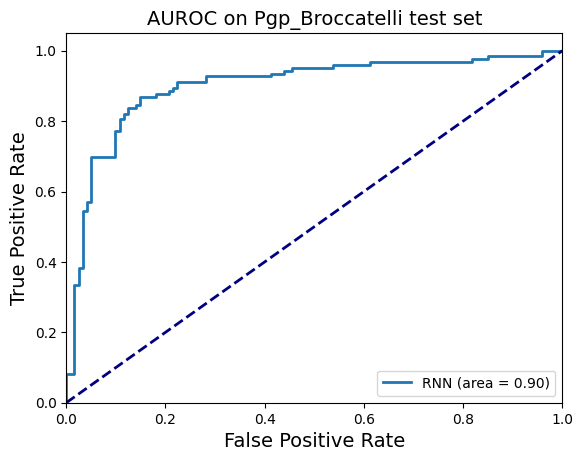

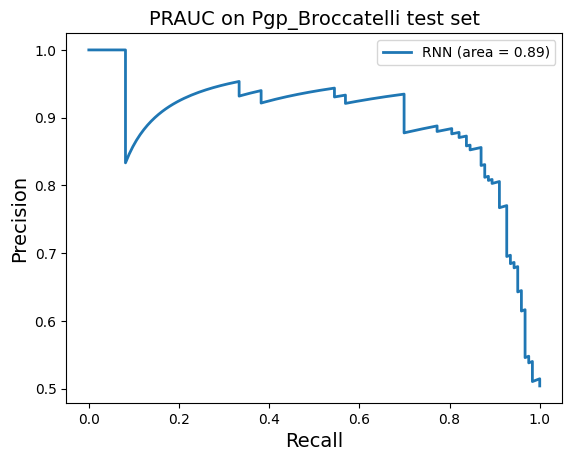

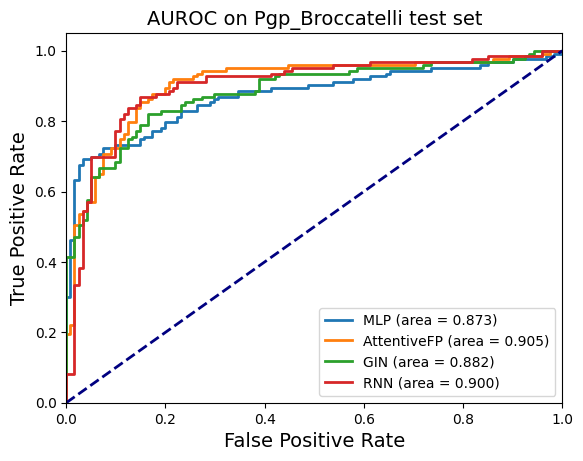

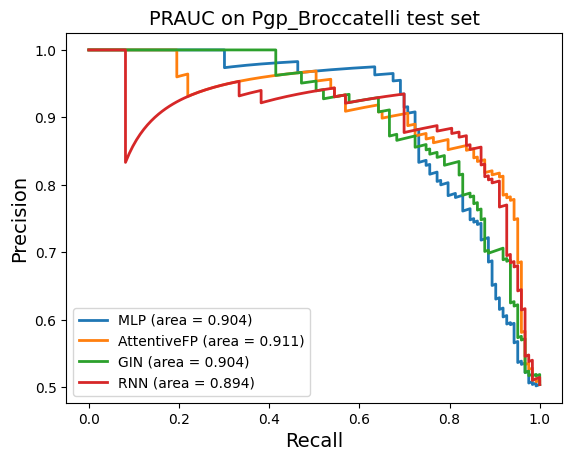

Found local copy...
Loading...
Done!


repeated num # 3 idx 0 has the lowest loss from [0.15497072041034698, 0.17277513444423676, 0.16850599646568298]
******************** HIA_Hou ******************** 
	|       acc      |       auc      |       ap      
	&0.945$\pm$0.004  &0.971$\pm$0.003  &0.994$\pm$0.001  
 idx 0: &0.948            &0.974            &0.995            

best model for HIA_Hou, MLP: cls/HIA_Hou/MLP_ST_0.yml
collect data for:  ['HIA_Hou']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  cls/HIA_Hou/MLP_ST_0.pt
[Test] Loss: 0.155
*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.948  &  0.884  &          0.960  &     0.979  &0.789  &0.969 &0.974 &   0.805 &   0.995


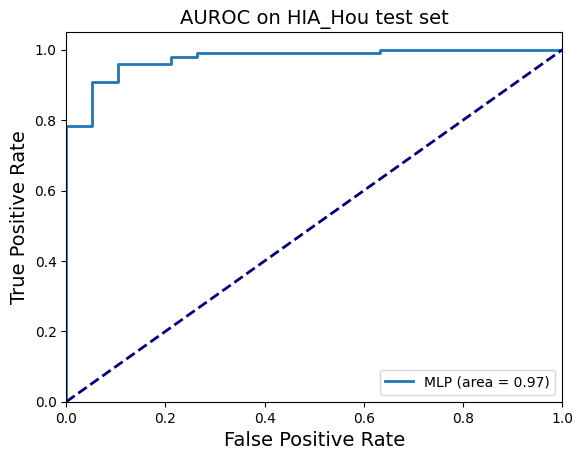

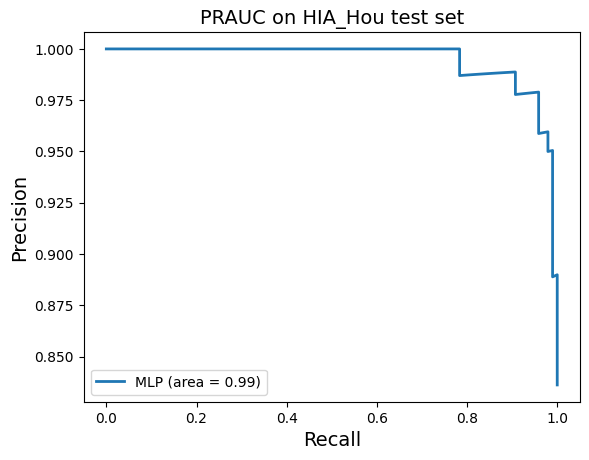

Found local copy...
Loading...
Done!


repeated num # 3 idx 0 has the lowest loss from [0.117405466735363, 0.14881983399391174, 0.15012875199317932]
******************** HIA_Hou ******************** 
	|       acc      |       auc      |       ap      
	&0.931$\pm$0.000  &0.967$\pm$0.010  &0.996$\pm$0.001  
 idx 0: &0.931            &0.981            &0.998            

best model for HIA_Hou, AttentiveFP: cls/HIA_Hou/AttentiveFP_ST_0.yml
collect data for:  ['HIA_Hou']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 116 out of 116 | elapsed:    0.2s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  cls/HIA_Hou/AttentiveFP_ST_0.pt
[Test] Loss: 0.112
*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.948  &  0.863  &          0.950  &     0.990  &0.737  &0.970 &0.991 &   0.801 &   0.998


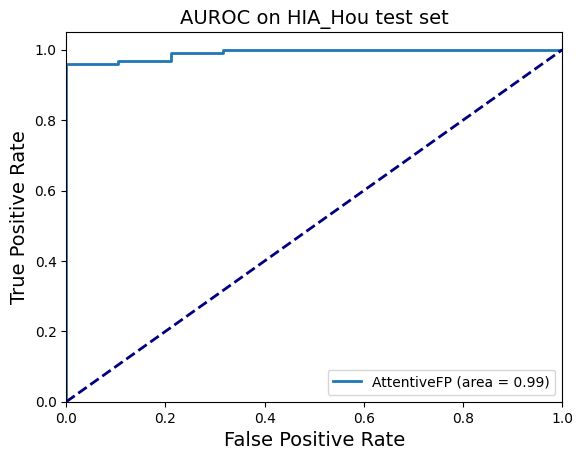

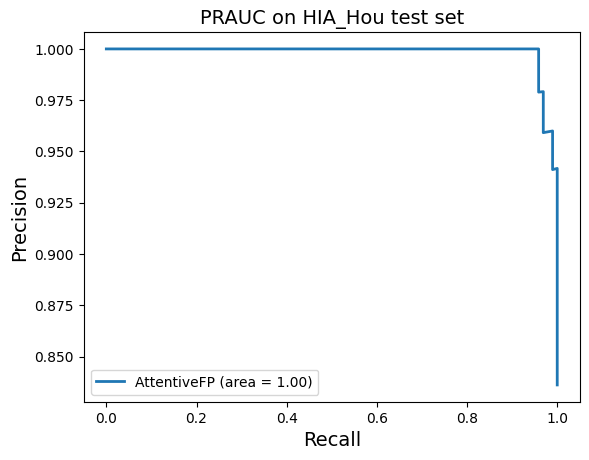

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [0.1394932121038437, 0.12294399738311768, 0.15606632828712463]
******************** HIA_Hou ******************** 
	|       acc      |       auc      |       ap      
	&0.931$\pm$0.000  &0.981$\pm$0.001  &0.996$\pm$0.000  
 idx 1: &0.931            &0.982            &0.997            

best model for HIA_Hou, GIN: cls/HIA_Hou/GIN_ST_1.yml
collect data for:  ['HIA_Hou']
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  cls/HIA_Hou/GIN_ST_1.pt
[Test] Loss: 0.123
*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.931  &  0.874  &          0.959  &     0.959  &0.789  &0.959 &0.982 &   0.748 &   0.997


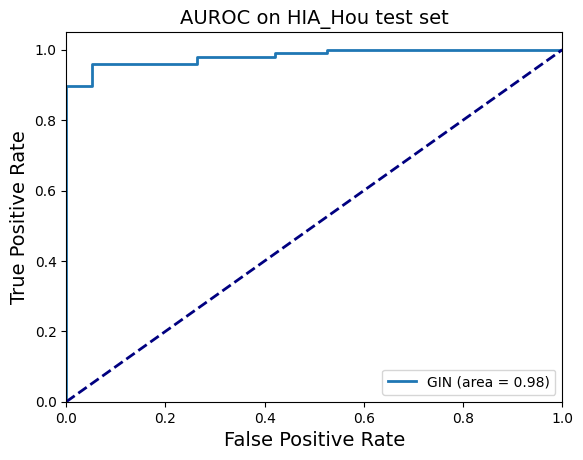

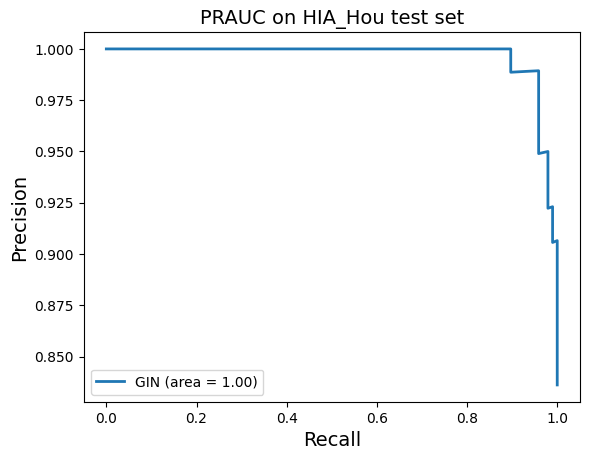

Found local copy...
Loading...
Done!



repeated num # 3 idx 0 has the lowest loss from [0.19581544399261475, 0.29137375950813293, 0.269471138715744]
******************** HIA_Hou ******************** 
	|       acc      |       auc      |       ap      
	&0.871$\pm$0.025  &0.944$\pm$0.007  &0.989$\pm$0.001  
 idx 0: &0.879            &0.954            &0.991            

best model for HIA_Hou, RNN: cls/HIA_Hou/RNN_ST_0.yml
collect data for:  ['HIA_Hou']
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  cls/HIA_Hou/RNN_ST_0.pt
[Test] Loss: 0.196
*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.879  &  0.780  &          0.928  &     0.928  &0.632  &0.928 &0.954 &   0.559 &   0.991


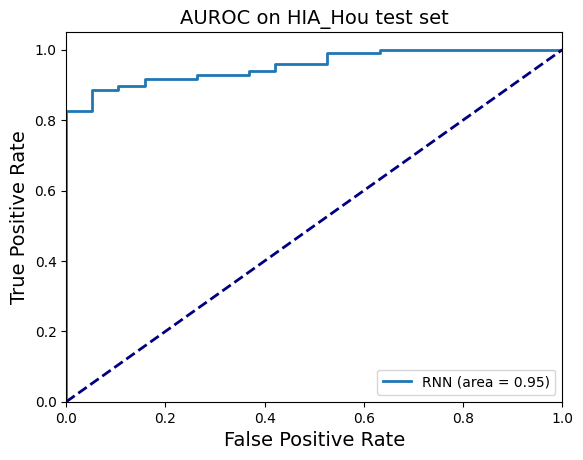

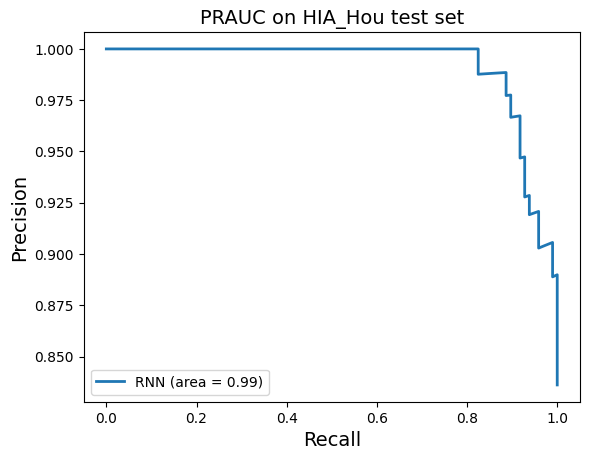

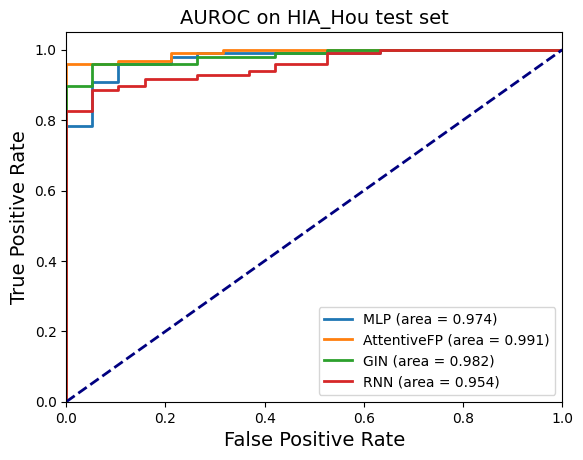

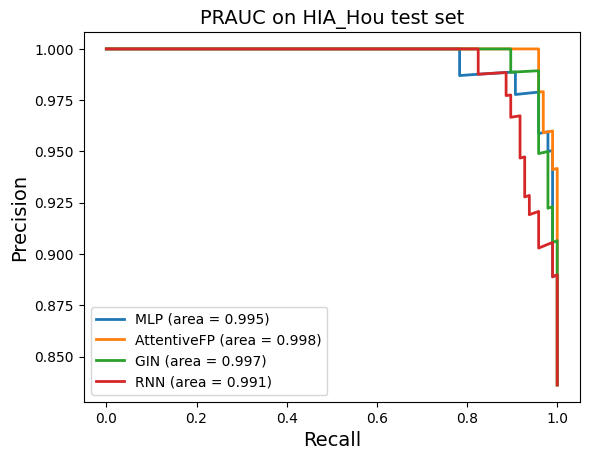

Found local copy...
Loading...
Done!


repeated num # 3 idx 0 has the lowest loss from [1.4658274948596954, 1.5125547051429749, 1.5828110873699188]
******************** PAMPA_NCATS ******************** 
	|       acc      |       auc      |       ap      
	&0.846$\pm$0.001  &0.759$\pm$0.021  &0.941$\pm$0.007  
 idx 0: &0.845            &0.780            &0.948            

best model for PAMPA_NCATS, MLP: cls/PAMPA_NCATS/MLP_ST_0.yml
collect data for:  ['PAMPA_NCATS']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  cls/PAMPA_NCATS/MLP_ST_0.pt
[Test] Loss: 0.366
*************** PAMPA_NCATS ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.845  &  0.513  &          0.849  &     0.994  &0.032  &0.916 &0.780 &   0.095 &   0.948


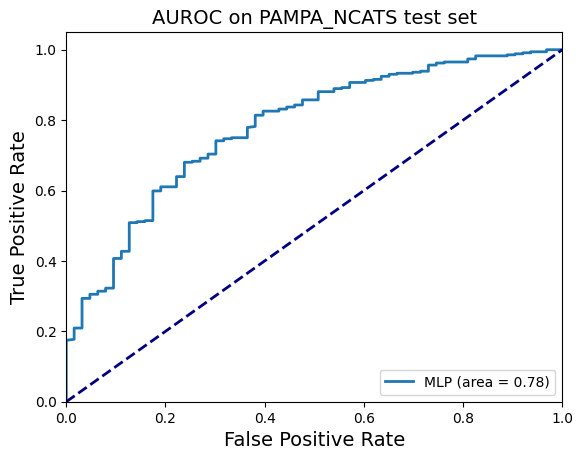

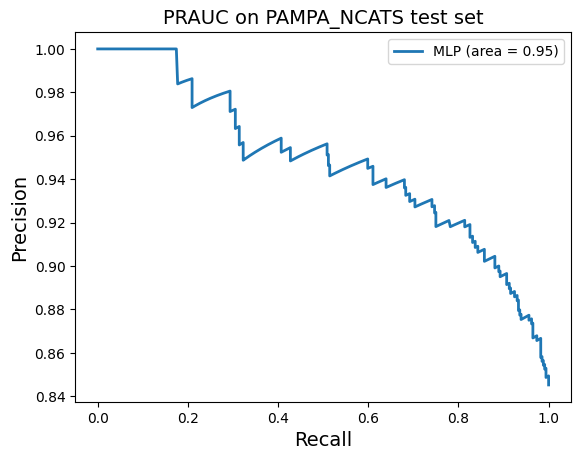

Found local copy...
Loading...
Done!



repeated num # 3 idx 0 has the lowest loss from [1.5424523651599884, 1.6174292862415314, 1.6093033850193024]
******************** PAMPA_NCATS ******************** 
	|       acc      |       auc      |       ap      
	&0.852$\pm$0.006  &0.734$\pm$0.013  &0.931$\pm$0.003  
 idx 0: &0.860            &0.748            &0.936            

best model for PAMPA_NCATS, AttentiveFP: cls/PAMPA_NCATS/AttentiveFP_ST_0.yml
collect data for:  ['PAMPA_NCATS']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 400 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 407 out of 407 | elapsed:    0.6s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  cls/PAMPA_NCATS/AttentiveFP_ST_0.pt
[Test] Loss: 0.386
*************** PAMPA_NCATS ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.860  &  0.599  &          0.873  &     0.977  &0.222  &0.922 &0.748 &   0.318 &   0.936


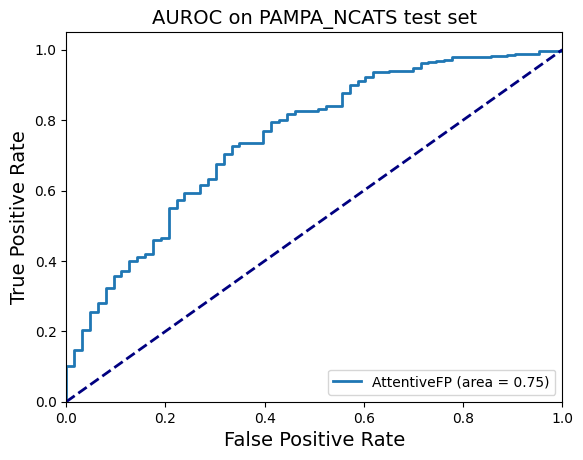

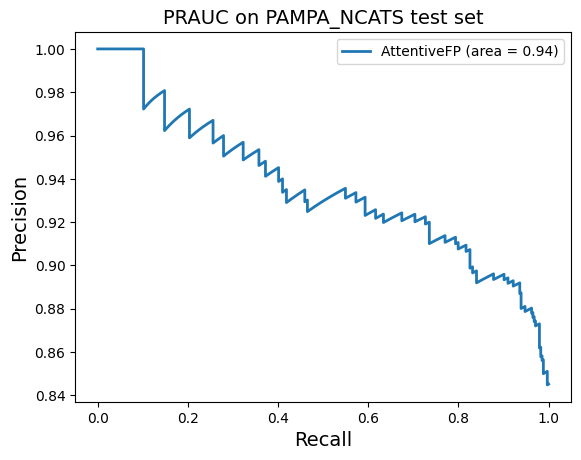

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [1.3835685551166534, 1.359668880701065, 1.3800307214260101]
******************** PAMPA_NCATS ******************** 
	|       acc      |       auc      |       ap      
	&0.871$\pm$0.003  &0.784$\pm$0.007  &0.945$\pm$0.002  
 idx 1: &0.875            &0.793            &0.946            

best model for PAMPA_NCATS, GIN: cls/PAMPA_NCATS/GIN_ST_1.yml
collect data for:  ['PAMPA_NCATS']
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  cls/PAMPA_NCATS/GIN_ST_1.pt
[Test] Loss: 0.340
*************** PAMPA_NCATS ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.875  &  0.667  &          0.893  &     0.968  &0.365  &0.929 &0.793 &   0.435 &   0.946


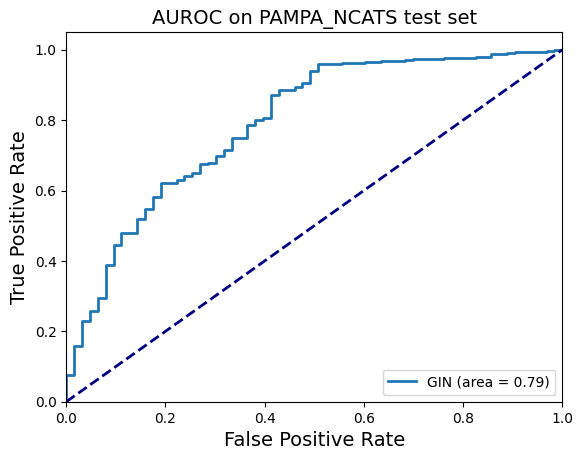

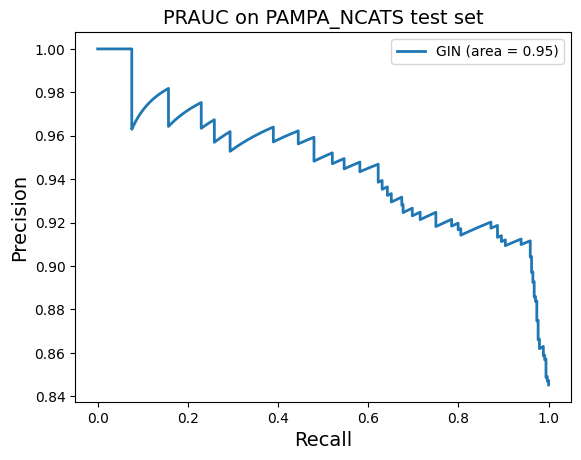

Found local copy...
Loading...
Done!



repeated num # 3 idx 0 has the lowest loss from [1.7578733265399933, 1.7724077701568604, 1.7860855460166931]
******************** PAMPA_NCATS ******************** 
	|       acc      |       auc      |       ap      
	&0.845$\pm$0.000  &0.511$\pm$0.003  &0.836$\pm$0.000  
 idx 0: &0.845            &0.516            &0.836            

best model for PAMPA_NCATS, RNN: cls/PAMPA_NCATS/RNN_ST_0.yml
collect data for:  ['PAMPA_NCATS']
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  cls/PAMPA_NCATS/RNN_ST_0.pt
[Test] Loss: 0.439
*************** PAMPA_NCATS ***************
at least 2 of TP, FP, TN, FN are 0, cannot cal MCC, set as -100
TP, FP, TN, FN 344 63 0 0
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.845  &  0.500  &          0.845  &     1.000  &0.000  &0.916 &0.516 &-100.000 &   0.836


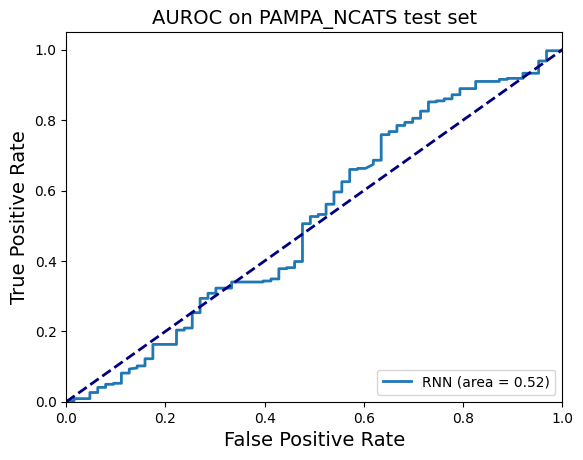

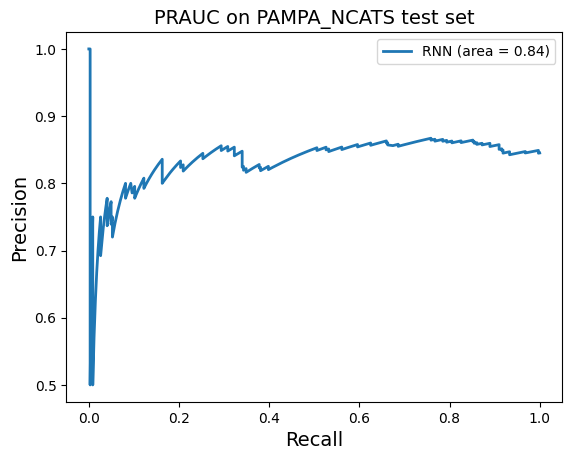

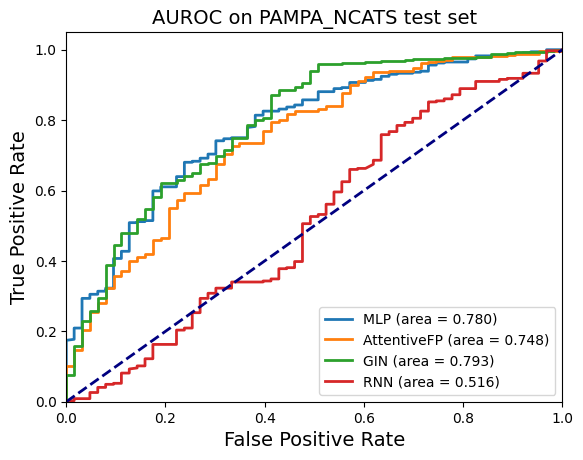

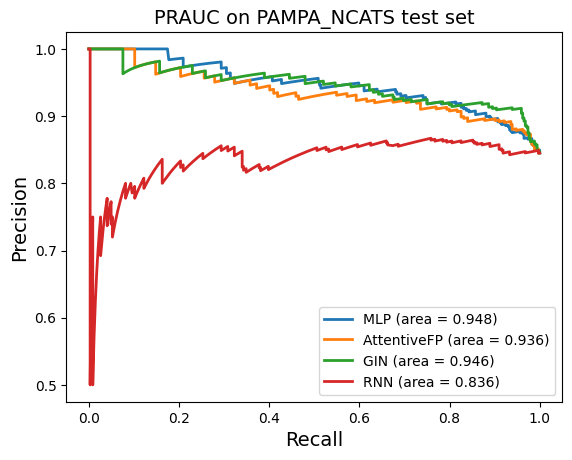

Found local copy...
Loading...
Done!


repeated num # 3 idx 1 has the lowest loss from [10.620829463005066, 10.257055461406708, 10.473958104848862]
******************** hERG_Karim ******************** 
	|       acc      |       auc      |       ap      
	&0.788$\pm$0.002  &0.862$\pm$0.005  &0.868$\pm$0.003  
 idx 1: &0.791            &0.867            &0.870            

best model for hERG_Karim, MLP: cls/hERG_Karim/MLP_ST_1.yml
collect data for:  ['hERG_Karim']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  cls/hERG_Karim/MLP_ST_1.pt
[Test] Loss: 0.466
*************** hERG_Karim ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.791  &  0.791  &          0.806  &     0.765  &0.816  &0.785 &0.867 &   0.582 &   0.870


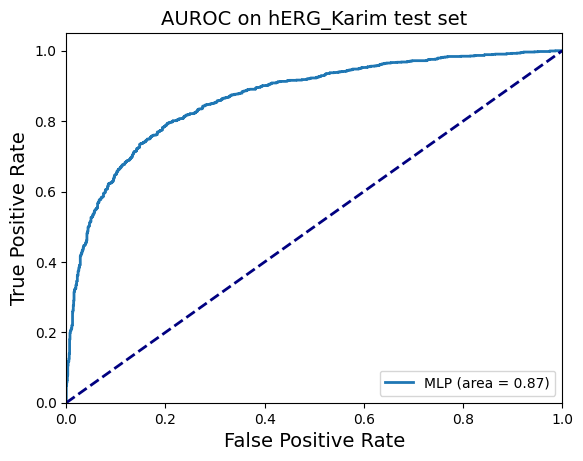

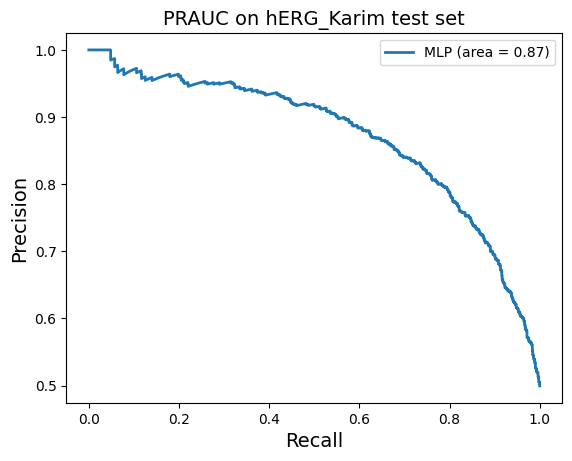

Found local copy...
Loading...
Done!


repeated num # 3 idx 2 has the lowest loss from [10.22041317820549, 10.023064851760864, 9.83233854174614]
******************** hERG_Karim ******************** 
	|       acc      |       auc      |       ap      
	&0.810$\pm$0.001  &0.889$\pm$0.006  &0.890$\pm$0.006  
 idx 2: &0.809            &0.897            &0.898            

best model for hERG_Karim, AttentiveFP: cls/hERG_Karim/AttentiveFP_ST_2.yml
collect data for:  ['hERG_Karim']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 1660 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 2689 out of 2689 | elapsed:    4.3s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  cls/hERG_Karim/AttentiveFP_ST_2.pt
[Test] Loss: 0.447
*************** hERG_Karim ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.809  &  0.809  &          0.827  &     0.780  &0.837  &0.803 &0.897 &   0.619 &   0.898


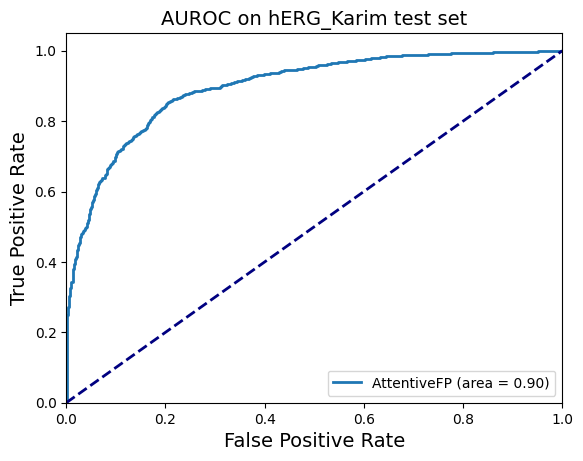

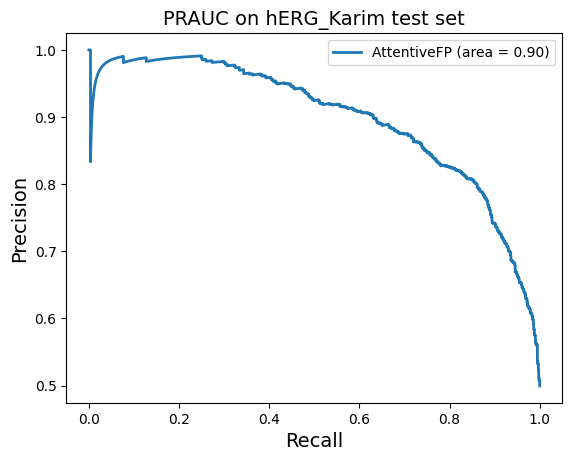


repeated num # 3 idx 2 has the lowest loss from [9.950141251087189, 9.914791762828827, 9.893103301525116]
******************** hERG_Karim ******************** 
	|       acc      |       auc      |       ap      
	&0.808$\pm$0.006  &0.890$\pm$0.003  &0.897$\pm$0.002  
 idx 2: &0.816            &0.894            &0.901            

best model for hERG_Karim, GIN: cls/hERG_Karim/GIN_ST_2.yml


Found local copy...
Loading...
Done!


collect data for:  ['hERG_Karim']
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  cls/hERG_Karim/GIN_ST_2.pt
[Test] Loss: 0.450
*************** hERG_Karim ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.816  &  0.816  &          0.822  &     0.805  &0.826  &0.813 &0.894 &   0.631 &   0.901


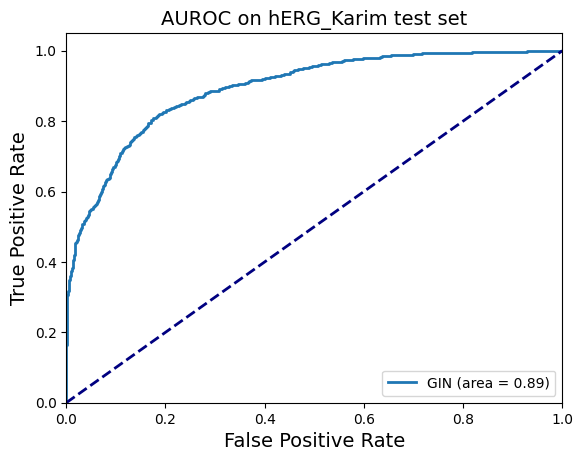

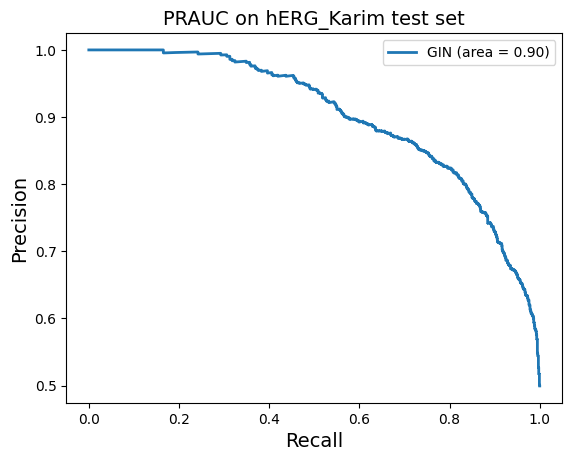

Found local copy...
Loading...
Done!



repeated num # 3 idx 0 has the lowest loss from [10.663560777902603, 10.980237036943436, 10.839368969202042]
******************** hERG_Karim ******************** 
	|       acc      |       auc      |       ap      
	&0.750$\pm$0.011  &0.834$\pm$0.006  &0.836$\pm$0.004  
 idx 0: &0.765            &0.843            &0.842            

best model for hERG_Karim, RNN: cls/hERG_Karim/RNN_ST_0.yml
collect data for:  ['hERG_Karim']
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  cls/hERG_Karim/RNN_ST_0.pt
[Test] Loss: 0.485
*************** hERG_Karim ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.765  &  0.765  &          0.796  &     0.711  &0.819  &0.751 &0.843 &   0.533 &   0.842


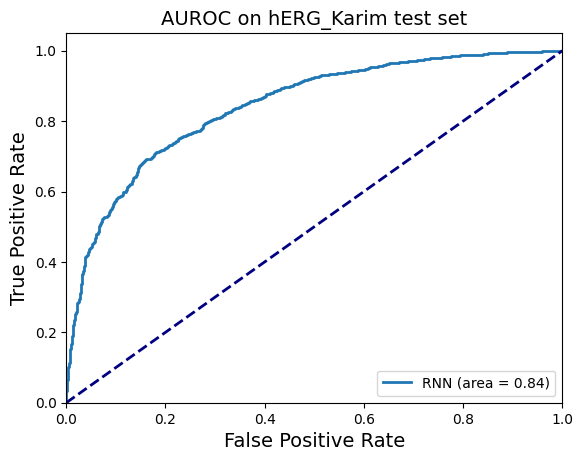

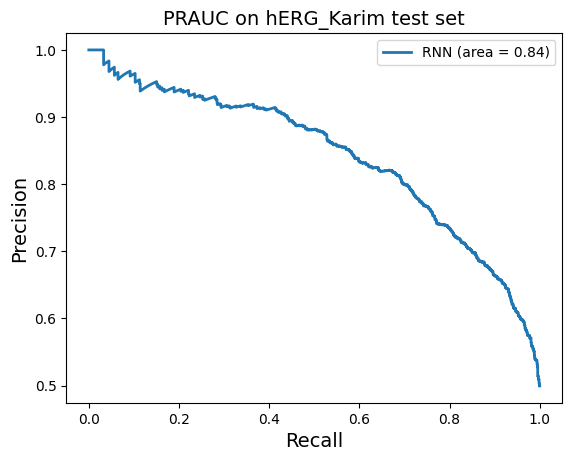

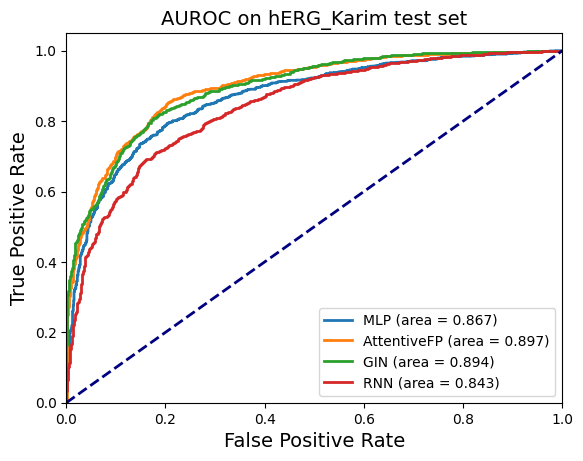

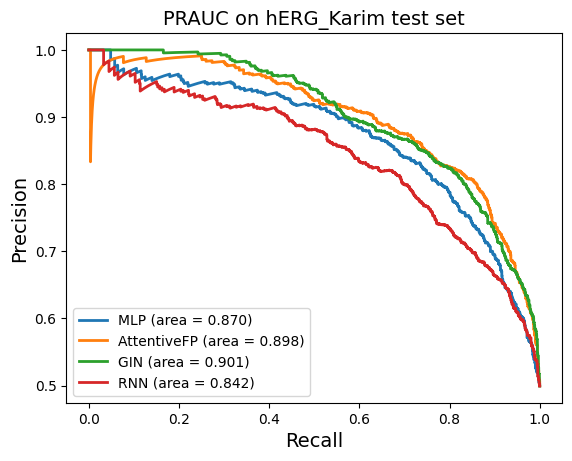

Found local copy...
Loading...
Done!


repeated num # 3 idx 1 has the lowest loss from [5.444633960723877, 5.409849524497986, 5.690922290086746]
******************** AMES ******************** 
	|       acc      |       auc      |       ap      
	&0.803$\pm$0.007  &0.862$\pm$0.008  &0.867$\pm$0.011  
 idx 1: &0.809            &0.869            &0.875            

best model for AMES, MLP: cls/AMES/MLP_ST_1.yml
collect data for:  ['AMES']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  30817
finish load data status 

load pretrained model from  cls/AMES/MLP_ST_1.pt
[Test] Loss: 0.451
*************** AMES ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.809  &  0.804  &          0.804  &     0.861  &0.746  &0.832 &0.869 &   0.614 &   0.875


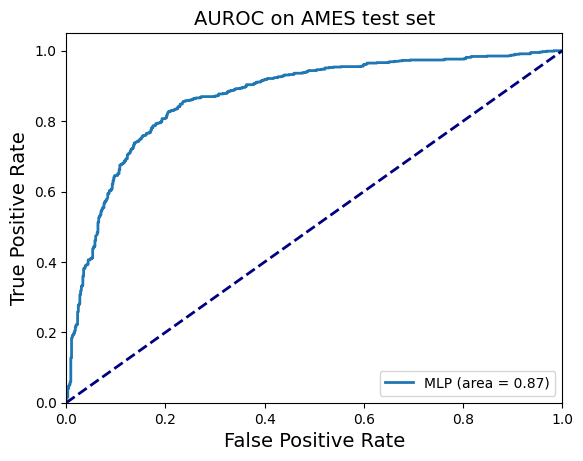

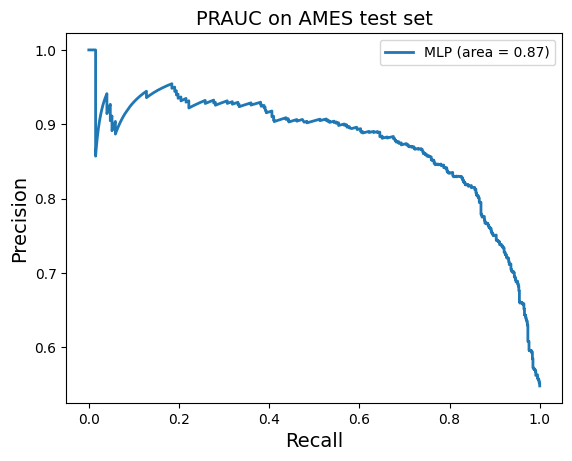

Found local copy...
Loading...
Done!



repeated num # 3 idx 2 has the lowest loss from [2.631822317838669, 2.5923390686511993, 2.58170622587204]
******************** AMES ******************** 
	|       acc      |       auc      |       ap      
	&0.821$\pm$0.008  &0.882$\pm$0.002  &0.898$\pm$0.003  
 idx 2: &0.830            &0.884            &0.900            

best model for AMES, AttentiveFP: cls/AMES/AttentiveFP_ST_2.yml
collect data for:  ['AMES']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 1350 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 1456 out of 1456 | elapsed:    1.7s finished


Model type:  AttentiveFP | Model parameters:  3823507
finish load data status 

load pretrained model from  cls/AMES/AttentiveFP_ST_2.pt
[Test] Loss: 0.434
*************** AMES ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.812  &  0.808  &          0.818  &     0.845  &0.772  &0.831 &0.882 &   0.619 &   0.895


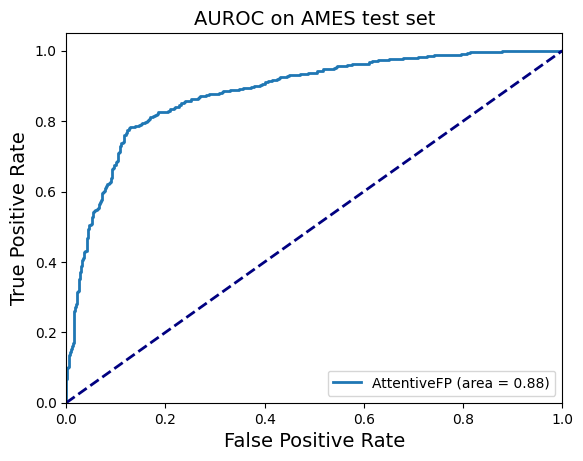

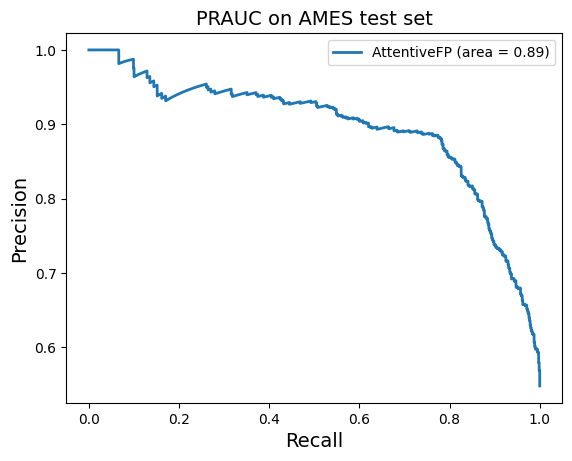

Found local copy...
Loading...
Done!



repeated num # 3 idx 1 has the lowest loss from [5.071057051420212, 5.046832472085953, 5.072369277477264]
******************** AMES ******************** 
	|       acc      |       auc      |       ap      
	&0.812$\pm$0.003  &0.889$\pm$0.001  &0.904$\pm$0.001  
 idx 1: &0.812            &0.891            &0.905            

best model for AMES, GIN: cls/AMES/GIN_ST_1.yml
collect data for:  ['AMES']
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
finish load data status 

Pretrained model loaded
load pretrained model from  cls/AMES/GIN_ST_1.pt
[Test] Loss: 0.421
*************** AMES ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.812  &  0.809  &          0.817  &     0.848  &0.769  &0.832 &0.891 &   0.621 &   0.905


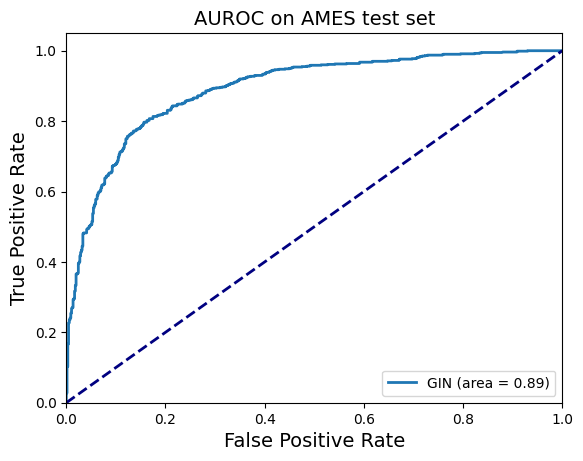

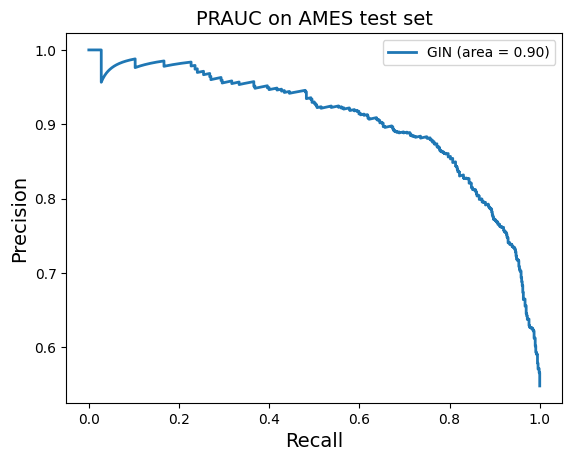

Found local copy...
Loading...
Done!



repeated num # 3 idx 0 has the lowest loss from [5.6611533761024475, 5.784149557352066, 5.941691607236862]
******************** AMES ******************** 
	|       acc      |       auc      |       ap      
	&0.783$\pm$0.012  &0.848$\pm$0.005  &0.854$\pm$0.005  
 idx 0: &0.790            &0.851            &0.859            

best model for AMES, RNN: cls/AMES/RNN_ST_0.yml
collect data for:  ['AMES']
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
finish load data status 

load pretrained model from  cls/AMES/RNN_ST_0.pt
[Test] Loss: 0.472
*************** AMES ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.790  &  0.783  &          0.785  &     0.850  &0.717  &0.816 &0.851 &   0.574 &   0.859


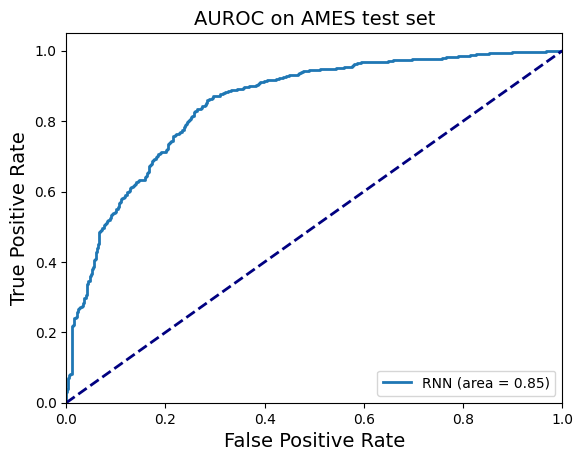

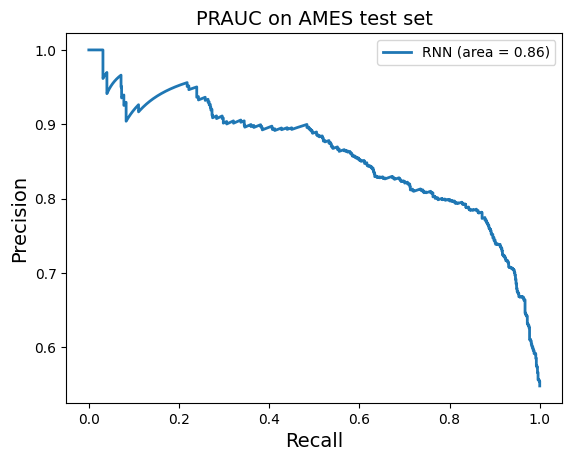

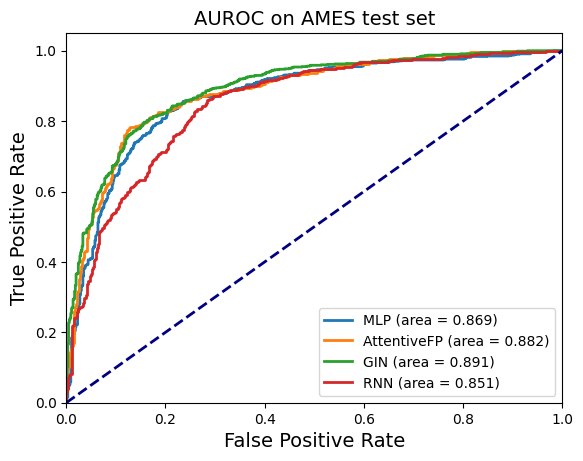

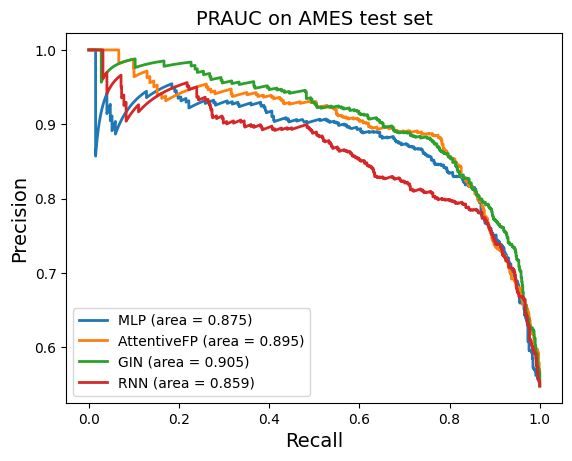

In [14]:
repeat_time = 3

for name in names_cls:
    folder_name = f'cls/{name}' # check scaleed result
    perfs, probs_list, label_list = [], [], []
    perfs_dict = {}
    for model_type in model_types:
        perfs = []
        for i in range(repeat_time):
            file_name = f'{folder_name}/{model_type}_ST_{i}.yml'
            try:
                p = yml_report(file_name)
                perfs.append(p)
            except:
                print(f'cannot open file {file_name}')
        best_idx = eval_perf_list(perfs, name, tok='&')
        file_name = f'{folder_name}/{model_type}_ST_{best_idx}.yml'
        print(f'best model for {name}, {model_type}: {file_name}')
        output = yml_report(file_name, return_all=True)
        p, probs, label = output
        perfs_dict[model_type] = p
        probs_list.append(probs[name])
        label_list.append(label[name])

    roc_curve_batch(probs_list, label_list, model_types, figure_title=name)
    prc_curve_batch(probs_list, label_list, model_types, figure_title=name)


#### read yml files examples

In [44]:

for name in names_reg:
    folder_list = [f'{name}_scale', f'{name}_no_scale']
    eval_multi_run('RNN', name, folder_list, run_type='ST', metrics_dict=d)

checking Caco2_Wang_scale
repeated num # 3 idx 0 has the lowest loss from [0.022208291095691723, 0.022280575154901863, 0.023003673815465236]
******************** Caco2_Wang ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.503 +/- 0.003 | 0.637 +/- 0.005 | 0.360 +/- 0.010 | 
 idx 0: | 0.505 +/- 0.000 | 0.633 +/- 0.000 | 0.369 +/- 0.000 | 

checking Caco2_Wang_no_scale
repeated num # 3 idx 0 has the lowest loss from [0.37956334208394144, 0.4216544182745965, 0.39517721239027087]
******************** Caco2_Wang ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.510 +/- 0.010 | 0.631 +/- 0.014 | 0.372 +/- 0.027 | 
 idx 0: | 0.497 +/- 0.000 | 0.616 +/- 0.000 | 0.402 +/- 0.000 | 


checking Lipophilicity_AstraZeneca_scale
repeated num # 3 idx 2 has the lowest loss from [0.01960491169066656, 0.02007693506422497, 0.018522064033008757]
******************** Lipophilicity_AstraZeneca ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.624 +/- 0.007 | 0.836 +/- 0.014 | 0.527 +/- 0.016 | 
 id

#### Test uncertainty weight

In [ ]:
name = ['Caco2_Wang', 'HydrationFreeEnergy_FreeSolv']
run_type = 'MT'
model_type = 'AttentiveFP'


trn, val, tst = collect_data(name)
scale_task = True
# from scripts.preprocess_mols import scale
trn, val, tst, dict_scale = scale(trn, val, tst, scale_task=scale_task)

config = get_config(model_type, name); config['scale_dict'] = dict_scale

trn_l, val_l, tst_l, vocab = get_multi_loader(trn, val, tst, config)

if vocab != None and config['vocab'] == None:
    """ If need vocab (RNN) yet no vocab provided: calculate using dataset """
    config['vocab'] = vocab # update config vocab info
    print('RNN, no vocab provided, update vocab using dataset | ', end="")
    print('vocab length updated:', len(vocab))


In [ ]:
folder_name = 'uw'
make_path(folder_name, False)
perfs = [] # a list to store the performance outputted from the model
repeat_time = 5
retrain = True
print('retrain model and delete past models: ', retrain)

for i in range(repeat_time): # run the same model for repeat_time times
    print(f'\nRun # {i} for {model_type} {run_type}', end='\t')
    save_dir = f'{folder_name}/{model_type}_{run_type}_{i}'
    print(' | save dir: ', save_dir)
    config['model_path']  = save_dir + '.pt'
    config['config_path'] = save_dir + '.yml'
    config['uncertainty_weight'] = True
    config['verbose_freq'] = 100
    config['patience'] = 30

    nofile = False
    if retrain == False:
        try: # try open yml file, if file exists, and no need train
            with open(config['config_path'], 'r') as f: data = yaml.safe_load(f)
            if data != None: p = yml_report(data); print('--> pre data loaded')
            nofile = False
        except:  nofile = True # model was not trained yet, train the model
    if nofile or retrain:

        models = PRED(**config); p = models.train(trn_l, val_l, tst_l)





    eval_perf_list(p, name, {}); perfs.append(p)
eval_perf_list(perfs, name)

In [ ]:
# p = yml_report(config['config_path'], ver=False)
# # eval_perf_list(p, name, metrics_dict={})
# eval_perf_list(p, name)
eval_perf_list(perfs, name)

In [ ]:
eval_multi_run(model_type, name, ['uw', 'uw_no'], repeat_time=5, run_type='MT')

## train single classification task

In [ ]:


def train_st_600_epoch(name, model_type, folder_name, repeat_time, retrain):
    """
    Aim: train classification task, single task
    param
        name:        str, name of task
        model_type:  str, model type
        folder_name: str, the dir of saved model and yml files
        repeat_time: int, repeat training the same model several times
        retrain:     bool,
                     if False, will check whether there exists pretrained
                     else:     retrain anyway and delete past files
    Return a list, each element is a dict, contain performance and train loss
    """
    run_type = 'ST' # single classification task
    make_path(folder_name, False)
    perfs = []
    trn, val, tst = collect_data(name) # no need to scale task for cls

    # check whether need scaling
    scale_dict = None
    if name in names_reg:
        trn, val, tst, scale_dict = scale(trn, val, tst, scale_task=True)

    config = get_config(model_type, name)
    config['scale_dict'] = scale_dict
    config['MAX_EPOCH'] = 600
    config['lr'] = 1e-4
    config['dropout'] = 0.3
    trn_l, val_l, tst_l, vocab = get_multi_loader(trn, val, tst, config)

    if vocab != None and config['vocab'] == None:
        config['vocab'] = vocab # update config vocab info
        print('RNN, no vocab provided, update vocab using dataset | ', end="")
        print('vocab length updated:', len(vocab))

    for i in range(repeat_time):
        print(f'\nRun # {i} for {model_type} {run_type}', end='\t')
        save_dir = f'{folder_name}/{model_type}_{run_type}_{i}'
        print(' | save dir: ', save_dir)
        config['model_path']  = save_dir + '.pt'
        config['config_path'] = save_dir + '.yml'
        config['uncertainty_weight'] = False # single task, no need uw
        config['verbose_freq'] = 100
        config['patience'] = 800
        nofile = False
        if retrain == False:
            try: # try open yml file, if file exists, and no need train
                with open(config['config_path'], 'r') as f: data = yaml.safe_load(f)
                if data != None: p = yml_report(data); print('--> pre data loaded')
                nofile = False
            except:  nofile = True # model was not trained yet, train the model
        if nofile or retrain:
            models = PRED(**config)
            p = models.train(trn_l, val_l, tst_l)

        eval_perf_list(p, name, {}); perfs.append(p)

    eval_perf_list(perfs, name)
    return perfs

# train 800 epoch no stop
names = ['CYP2D6_Veith', 'Lipophilicity_AstraZeneca']
for name in names:
    folder_name = 'long_run/'+ name
    make_path(folder_name)
    for model_type in model_types:
        perfs = train_st_800_epoch(name, model_type, folder_name,
                                   repeat_time=1, retrain=False)

In [ ]:
from scripts.CONSTANT import *

names = ['CYP2D6_Veith', 'Lipophilicity_AstraZeneca']

for name in names:
    # name = 'CYP2D6_Veith'
    folder_name = f'long_run/{name}'
    valid_dict_list, train_dict_list = [], []

    for model_type in model_types:
        print('*'*30, model_type, '*'*30)
        perfs, t_l, v_l = [], [], []
        for i in range(3):
            f = f'{folder_name}/{model_type}_ST_{i}.yml'
            with open(f, 'r') as d_: data = yaml.safe_load(d_)
            p = data['performance']
            t_l.append(data['train_dict'])
            v_l.append(data['valid_dict'])
            eval_perf_list(p, name, {})
            perfs.append(p)
        best_idx = eval_perf_list(perfs, name, d)
        print(best_idx,'\n\n')
        train_dict_list.append(t_l[best_idx])
        valid_dict_list.append(v_l[best_idx])

    from scripts.func_utils import *
    plot_performance(valid_dict_list, model_types, title=f'Valid loss during training on {name} regression (ST)')
    plot_performance(train_dict_list, model_types, title=f'Train loss during training on {name} regression (ST)')

In [ ]:

def train_cls_st(name, model_type, folder_name, repeat_time, retrain):
    """
    Aim: train classification task, single task
    param
        name:        str, name of task
        model_type:  str, model type
        folder_name: str, the dir of saved model and yml files
        repeat_time: int, repeat training the same model several times
        retrain:     bool,
                     if False, will check whether there exists pretrained
                     else:     retrain anyway and delete past files
    Return a list, each element is a dict, contain performance and train loss
    """
    run_type = 'ST' # single classification task
    make_path(folder_name, False)
    perfs = []
    trn, val, tst = collect_data(name) # no need to scale task
    config = get_config(model_type, name)
    trn_l, val_l, tst_l, vocab = get_multi_loader(trn, val, tst, config)

    if vocab != None and config['vocab'] == None:
        config['vocab'] = vocab # update config vocab info
        print('RNN, no vocab provided, update vocab using dataset | ', end="")
        print('vocab length updated:', len(vocab))

    for i in range(repeat_time):
        print(f'\nRun # {i} for {model_type} {run_type}', end='\t')
        save_dir = f'{folder_name}/{model_type}_{run_type}_{i}'
        print(' | save dir: ', save_dir)
        config['model_path']  = save_dir + '.pt'
        config['config_path'] = save_dir + '.yml'
        config['uncertainty_weight'] = False # single task, no need uw
        config['verbose_freq'] = 100
        config['patience'] = 30
        nofile = False
        if retrain == False:
            try: # try open yml file, if file exists, and no need train
                with open(config['config_path'], 'r') as f: data = yaml.safe_load(f)
                if data != None: p = yml_report(data); print('--> pre data loaded')
                nofile = False
            except:  nofile = True # model was not trained yet, train the model
        if nofile or retrain:
            models = PRED(**config)
            p = models.train(trn_l, val_l, tst_l)

        eval_perf_list(p, name, {}); perfs.append(p)

    eval_perf_list(perfs, name)
    return perfs


names = ['CYP2C19_Veith',
 'CYP2D6_Veith',
 'CYP3A4_Veith',
 'CYP1A2_Veith',
 'CYP2C9_Veith']

for name in names:
    folder_name = 'cls_rnn_selfies/' + name # classification single task
    perfs = train_cls_st(name, 'RNN', folder_name, 3, retrain=False)

In [ ]:
names = ['BBB_Martins',
 'Bioavailability_Ma',
 'Pgp_Broccatelli',
 'HIA_Hou',
 'PAMPA_NCATS',
 'hERG_Karim',
 'AMES']

# selfies for classification tasks
for name in names:
    folder_name = 'cls_rnn_selfies/' + name # classification single task
    perfs = train_cls_st(name, 'RNN', folder_name, 3, retrain=False)

In [12]:
model_type = 'RNN'
for name in names_cls:
    try:

        yml_names = [f'cls_rnn_selfies/{name}/{model_type}_ST_{i}.yml' for i in range(3)]
        ps = [yml_report(f, ver=False) for f in yml_names]
        eval_perf_list(ps, name, {})

    except:
        print('cannot handle ', name)

repeated num # 3 idx 2 has the lowest loss from [10.168385088443756, 10.16455927491188, 10.108901172876358]
******************** CYP2C19_Veith ******************** 
	|       acc      |       w_acc      |       prec      |       recall      |       sp      |       f1      |       auc      |       mcc      |       ap      
	&0.766$\pm$0.007  &0.770$\pm$0.006  &0.711$\pm$0.012  &0.827$\pm$0.020  &0.714$\pm$0.022  &0.764$\pm$0.006  &0.837$\pm$0.004  &0.541$\pm$0.012  &0.784$\pm$0.004  
 idx 2: &0.765            &0.768            &0.720            &0.800            &0.736            &0.758            &0.832            &0.534            &0.780            

repeated num # 3 idx 2 has the lowest loss from [7.941761359572411, 8.040668338537216, 7.927883982658386]
******************** CYP2D6_Veith ******************** 
	|       acc      |       w_acc      |       prec      |       recall      |       sp      |       f1      |       auc      |       mcc      |       ap      
	&0.846$\pm$0.004  &0